In [1]:
%matplotlib notebook
#import matplotlib.pyplot as plt
# Note! ITK interacts weirdly here.  from lazy_imports import itk does not work.
# Additionally, import itk must occur before lazy_imports for itkwidgets.view (ie itkview) to work.
import itk
#from lazy_imports import itk
from lazy_imports import np
from lazy_imports import plt
from lazy_imports import sitk
from lazy_imports import loadmat, savemat
from lazy_imports import sitk
from lazy_imports import itkwidgets
from lazy_imports import itkview
from lazy_imports import interactive
from lazy_imports import ipywidgets
from lazy_imports import pv

plt.rcParams["figure.figsize"] = (6, 6) # (w, h)

In [2]:
from disp.vis import show_2d, show_2d_tensors
from disp.vis import vis_tensors, vis_path
from disp.vis import view_3d_tensors, tensors_to_mesh, view_3d_paths, path_to_tube

In [3]:
from data.io import readRaw, ReadScalars, ReadTensors, WriteTensorNPArray, WriteScalarNPArray, readPath3D
from data.convert import GetNPArrayFromSITK, GetSITKImageFromNP

In [4]:
import algo.metricModSolver as mms
from algo import geodesic, euler
from util import tensors

In [5]:
import pickle
import math
import os

In [6]:
import sys
sys.path.append('/home/sci/kris/Software/Atlas-Building-3D/')
from mtch.RegistrationFunc3D import *

In [7]:
import ipywebrtc
from IPython.display import display
import time

# Display Configuration

In [8]:
# from colorbrewer2, sequential 9 values pasted together YlGnBu (reverse order) then YlOrRd
# EXCEPT THESE ARE NOT PRINT FRIENDLY OR PHOTOCOPY SAFE!!!
# But skip the yellows in the middle -- too light
geo_colors = ['tab:red', 'tab:pink', 'tab:orange', 'tab:blue', 'tab:purple', 'tab:green', 'tab:cyan']
eul_colors = ['k', 'tab:gray', 'tab:brown', 'm', 'y', 'tab:olive', 'maroon']
#interp_colors = ['#081d58', '#253494', '#225ea8', '#1d91c0', '#41b6c4', '#7fcdbb', '#c7e9b4', '#edf8b1', '#ffffd9',
#                 '#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']
interp_colors = ['#081d58', '#253494', '#225ea8', '#1d91c0', '#41b6c4', '#7fcdbb', '#c7e9b4',
                 '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']
# Compromise, use 5 class YlGnBu (reverse order) and YlOrBr again leaving out yellow
#interp_colors = ['#253494', '#2c7fb8', '#41b6c4', '#a1dab4', '#fed98e', '#fe9929', '#d95f0e', '#993404']

#animation_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/IPMI2021Presentation/atlas_3D_animation/'
#atlas_geo_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/IPMI2021Presentation/'

# Viewer Utilities

In [9]:
def tens_6_to_tens_3x3(tens):
  tens_full = np.zeros((tens.shape[0], tens.shape[1], tens.shape[2], 3, 3))
  tens_full[:,:,:,0,0] = tens[:,:,:,0]
  tens_full[:,:,:,0,1] = tens[:,:,:,1]
  tens_full[:,:,:,1,0] = tens[:,:,:,1]
  tens_full[:,:,:,0,2] = tens[:,:,:,2]
  tens_full[:,:,:,2,0] = tens[:,:,:,2]
  tens_full[:,:,:,1,1] = tens[:,:,:,3]
  tens_full[:,:,:,1,2] = tens[:,:,:,4]
  tens_full[:,:,:,2,1] = tens[:,:,:,4]
  tens_full[:,:,:,2,2] = tens[:,:,:,5]
  return(tens_full)

def tens_3x3_to_tens_6(tens):
  tens_tri = np.zeros((tens.shape[0], tens.shape[1], tens.shape[2], 6))
  tens_tri[:,:,:,0] = tens[:,:,:,0,0]
  tens_tri[:,:,:,1] = tens[:,:,:,0,1]
  tens_tri[:,:,:,2] = tens[:,:,:,0,2]
  tens_tri[:,:,:,3] = tens[:,:,:,1,1]
  tens_tri[:,:,:,4] = tens[:,:,:,1,2]
  tens_tri[:,:,:,5] = tens[:,:,:,2,2]
  return(tens_tri)


In [10]:
def evecs_to_ellipses(evecs, evals, fa, mask, scale):
  # convert eigenvectors and eigenvalues to pyvista PolyData Ellipsoids.  \
  
  principal_evecs = np.einsum('jkl,jklm->jklm',evals[:,:,:,2], evecs[:,:,:,:,2])
  evec_mags = np.linalg.norm(principal_evecs, axis=3)
  reds = fa[:,:,:] * np.abs(principal_evecs[:,:,:,0] / evec_mags[:,:,:])
  greens = fa[:,:,:] * np.abs(principal_evecs[:,:,:,1] / evec_mags[:,:,:])
  blues = fa[:,:,:] * np.abs(principal_evecs[:,:,:,2] / evec_mags[:,:,:])
  ptlist = []
  eig_vecs = []
  ellipses = []
  colors = []
  opacities = []
  for xx in range(mask.shape[0]):
    ptlist.append([])
    eig_vecs.append([])
    ellipses.append([])
    colors.append([])
    opacities.append([])
    for yy in range(mask.shape[1]):
      ptlist[xx].append([])
      eig_vecs[xx].append([])
      ellipses[xx].append([])
      colors[xx].append([])
      opacities[xx].append([])
      for zz in range(mask.shape[2]):
        if (mask is None) or mask[xx,yy,zz]:
          ptlist[xx][yy].append([zz,yy,xx])
          #eig_vecs[xx][yy].append([evals[xx,yy,zz,2]*evecs[xx,yy,zz,2,2], 
          #                         evals[xx,yy,zz,2]*evecs[xx,yy,zz,1,2], 
          #                         evals[xx,yy,zz,2]*evecs[xx,yy,zz,0,2]])
          eig_vecs[xx][yy].append([principal_evecs[xx,yy,zz,2], 
                                   principal_evecs[xx,yy,zz,1], 
                                   principal_evecs[xx,yy,zz,0]])  
          ellipses[xx][yy].append(pv.ParametricEllipsoid(evals[xx,yy,zz,2]/scale, 
                                                         evals[xx,yy,zz,1]/scale, 
                                                         evals[xx,yy,zz,0]/scale,
                                                         center=[zz,yy,xx], 
                                                         direction=[evecs[xx,yy,zz,2,2],
                                                                    evecs[xx,yy,zz,1,2],
                                                                    evecs[xx,yy,zz,0,2]])) 
          #ptlist[xx][yy].append([xx,yy,zz])
          ##eig_vecs[xx][yy].append([evals[xx,yy,zz,2]*evecs[xx,yy,zz,2,2], 
          ##                         evals[xx,yy,zz,2]*evecs[xx,yy,zz,1,2], 
          ##                         evals[xx,yy,zz,2]*evecs[xx,yy,zz,0,2]])
          #eig_vecs[xx][yy].append([principal_evecs[xx,yy,zz,0], 
          #                         principal_evecs[xx,yy,zz,1], 
          #                         principal_evecs[xx,yy,zz,2]])  
          #ellipses[xx][yy].append(pv.ParametricEllipsoid(evals[xx,yy,zz,0]/scale, 
          #                                               evals[xx,yy,zz,1]/scale, 
          #                                               evals[xx,yy,zz,2]/scale,
          #                                               center=[xx,yy,zz], 
          #                                               direction=[evecs[xx,yy,zz,0,2],
          #                                                          evecs[xx,yy,zz,1,2],
          #                                                          evecs[xx,yy,zz,2,2]])) 
          #colors[xx][yy].append([reds[xx,yy,zz], greens[xx,yy,zz], blues[xx,yy,zz]])
          colors[xx][yy].append([0,0,0])
          opacities[xx][yy].append(0.5)
        else:
          ptlist[xx][yy].append(None)
          eig_vecs[xx][yy].append(None)
          ellipses[xx][yy].append(None)
          colors[xx][yy].append(None)
          opacities[xx][yy].append(None)

  return(ptlist, eig_vecs, ellipses, colors, opacities)

def evecs_to_ellipses_v2(evecs, evals, fa, mask, xrng=None, yrng=None, zrng=None, stride=1, scale=None):
  # convert eigenvectors and eigenvalues to pyvista PolyData Ellipsoids.  \
  
  # If scale is None, normalize the ellipses,
  # otherwise scale unnormalized ellipses by scale.
  # Ellipses provided for each voxel, striding in xrng, yrng, zrng where mask == 1
  if xrng is None:
    xrng = [0,mask.shape[0]]
  if yrng is None:
    yrng = [0, mask.shape[1]]
  if zrng is None:
    zrng = [0, mask.shape[2]]
  
  principal_evecs = np.einsum('jkl,jklm->jklm',evals[:,:,:,2], evecs[:,:,:,:,2])
  evec_mags = np.linalg.norm(principal_evecs, axis=3)
  # Factor of 2 below only to get brighter colors, since don't know how to remove shading
  reds = 2 * fa[:,:,:] * np.abs(principal_evecs[:,:,:,0] / evec_mags[:,:,:])
  greens = 2 * fa[:,:,:] * np.abs(principal_evecs[:,:,:,1] / evec_mags[:,:,:])
  blues = 2 * fa[:,:,:] * np.abs(principal_evecs[:,:,:,2] / evec_mags[:,:,:])
  reds[reds>1]=1
  greens[greens>1]=1
  blues[blues>1]=1
  ptlist = []
  eig_vecs = []
  ellipses = []
  colors = []
  opacities = []
  for xx in range(xrng[0],xrng[1],stride):
    #ptlist.append([])
    #eig_vecs.append([])
    #ellipses.append([])
    #colors.append([])
    #opacities.append([])
    for yy in range(yrng[0],yrng[1],stride):
      #ptlist[xx].append([])
      #eig_vecs[xx].append([])
      #ellipses[xx].append([])
      #colors[xx].append([])
      #opacities[xx].append([])
      #for zz in range(zrng[0],zrng[1],stride):
      for zz in range(zrng[0],zrng[1],1):
        if (mask is None) or mask[xx,yy,zz]:
          #ptlist[xx][yy].append([zz,yy,xx])
          ##eig_vecs[xx][yy].append([evals[xx,yy,zz,2]*evecs[xx,yy,zz,2,2], 
          ##                         evals[xx,yy,zz,2]*evecs[xx,yy,zz,1,2], 
          ##                         evals[xx,yy,zz,2]*evecs[xx,yy,zz,0,2]])
          #eig_vecs[xx][yy].append([principal_evecs[xx,yy,zz,2], 
          #                         principal_evecs[xx,yy,zz,1], 
          #                         principal_evecs[xx,yy,zz,0]])  
          #ellipses[xx][yy].append(pv.ParametricEllipsoid(evals[xx,yy,zz,2]/scale, 
          #                                               evals[xx,yy,zz,1]/scale, 
          #                                               evals[xx,yy,zz,0]/scale,
          #                                               center=[zz,yy,xx], 
          #                                               direction=[evecs[xx,yy,zz,2,2],
          #                                                          evecs[xx,yy,zz,1,2],
          #                                                          evecs[xx,yy,zz,0,2]])) 
          ##ptlist[xx][yy].append([xx,yy,zz])
          ###eig_vecs[xx][yy].append([evals[xx,yy,zz,2]*evecs[xx,yy,zz,2,2], 
          ###                         evals[xx,yy,zz,2]*evecs[xx,yy,zz,1,2], 
          ###                         evals[xx,yy,zz,2]*evecs[xx,yy,zz,0,2]])
          ##eig_vecs[xx][yy].append([principal_evecs[xx,yy,zz,0], 
          ##                         principal_evecs[xx,yy,zz,1], 
          ##                         principal_evecs[xx,yy,zz,2]])  
          ##ellipses[xx][yy].append(pv.ParametricEllipsoid(evals[xx,yy,zz,0]/scale, 
          ##                                               evals[xx,yy,zz,1]/scale, 
          ##                                               evals[xx,yy,zz,2]/scale,
          ##                                               center=[xx,yy,zz], 
          ##                                               direction=[evecs[xx,yy,zz,0,2],
          ##                                                          evecs[xx,yy,zz,1,2],
          ##                                                          evecs[xx,yy,zz,2,2]])) 
          ##colors[xx][yy].append([reds[xx,yy,zz], greens[xx,yy,zz], blues[xx,yy,zz]])
          #colors[xx][yy].append([0,0,0])
          #opacities[xx][yy].append(0.5)
        
          ptlist.append([zz,yy,xx])
          #eig_vecs[xx][yy].append([evals[xx,yy,zz,2]*evecs[xx,yy,zz,2,2], 
          #                         evals[xx,yy,zz,2]*evecs[xx,yy,zz,1,2], 
          #                         evals[xx,yy,zz,2]*evecs[xx,yy,zz,0,2]])
          #eig_vecs[xx][yy].append([principal_evecs[xx,yy,zz,2], 
          #                         principal_evecs[xx,yy,zz,1], 
          #                         principal_evecs[xx,yy,zz,0]])  
          ellipses.append(pv.ParametricEllipsoid(evals[xx,yy,zz,2]/scale, 
                                                 evals[xx,yy,zz,1]/scale, 
                                                 evals[xx,yy,zz,0]/scale,
                                                 center=[zz,yy,xx], 
                                                 direction=[evecs[xx,yy,zz,2,2],
                                                            evecs[xx,yy,zz,1,2],
                                                            evecs[xx,yy,zz,0,2]]))
          colors.append([reds[xx,yy,zz], greens[xx,yy,zz], blues[xx,yy,zz]])
          #colors.append([0,0,0])
          opacities.append(0.5)
        else:
          #ptlist[xx][yy].append(None)
          #eig_vecs[xx][yy].append(None)
          #ellipses[xx][yy].append(None)
          #colors[xx][yy].append(None)
          #opacities[xx][yy].append(None)
          pass

  #return(ptlist, eig_vecs, ellipses, colors, opacities)
  return(ellipses, colors, opacities)

In [11]:
def ellipses_to_mesh(ptlist, eig_vecs, ellipses, colors, opacities, mask, xrng=None, yrng=None, zrng=None, stride=1, scale=None):
  # select appropriate points, ellipses and colors.
  # If scale is None, normalize the ellipses,
  # otherwise scale unnormalized ellipses by scale.
  # Ellipses provided for each voxel, striding in xrng, yrng, zrng where mask == 1
  if xrng is None:
    xrng = [0,mask.shape[0]]
  if yrng is None:
    yrng = [0, mask.shape[1]]
  if zrng is None:
    zrng = [0, mask.shape[2]]

  sm_ptlist = []
  sm_ellipses = []
  sm_colors = []
  sm_opacs = []
  sm_eig_vecs = []
  for xx in range(xrng[0],xrng[1],stride):
    for yy in range(yrng[0],yrng[1],stride):
      for zz in range(zrng[0],zrng[1],stride):
        if (mask is None) or mask[xx,yy,zz]:
          sm_ptlist.append(ptlist[xx][yy][zz])
          sm_eig_vecs.append(eig_vecs[xx][yy][zz])
          sm_ellipses.append(ellipses[xx][yy][zz]) 
          sm_colors.append(colors[xx][yy][zz])
          sm_opacs.append(opacities[xx][yy][zz])
        
  if len(sm_ptlist) > 0:
    print(len(sm_ptlist))
    ptdata = pv.wrap(np.array(sm_ptlist))
    ptdata.vectors = -np.array(sm_eig_vecs)                      
    mesh = ptdata.glyph(geom=sm_ellipses, orient='_vectors',scale=True,tolerance=0.005, 
                        factor = 1./(scale*scale), progress_bar=True)#, factor=5)
    #pt_mesh.vectors = -np.array(eig_vec_arr)
  else:
    print(len(sm_ptlist),zrng)
    ptdata = pv.wrap(np.array([[0,0,0]]))
    mesh = ptdata.glyph(geom=[pv.ParametricEllipsoid(0.001, 0.001, 0.001)],scale=False, tolerance=0.005)

  return(mesh, sm_ellipses, sm_colors, sm_opacs)

def evecs_to_mesh(evecs, evals, mask, xrng=None, yrng=None, zrng=None, stride=None, scale=None):
  # convert eigenvectors and eigenvalues to pyvista PolyData Ellipsoids.  If scale is None, normalize the ellipses,
  # otherwise scale unnormalized ellipses by scale.
  # Ellipses provided for each voxel, striding in xrng, yrng, zrng where mask == 1
  if xrng is None:
    xrng = [0,mask.shape[0]]
  if yrng is None:
    yrng = [0, mask.shape[1]]
  if zrng is None:
    zrng = [0, mask.shape[2]]
  if stride is None:
    stride = 4
  if scale is None:
    scale = 1

  ptlist = []
  eig_vec_arr = []
  eig_val_arr = []
  ellipses = []
  for xx in range(xrng[0],xrng[1],stride):
    for yy in range(yrng[0],yrng[1],stride):
      for zz in range(zrng[0],zrng[1],stride):
        if (mask is None) or mask[xx,yy,zz]:
          ptlist.append([zz,yy,xx])
          eig_vec_arr.append([evals[xx,yy,zz,2]*evecs[xx,yy,zz,2,2], 
                              evals[xx,yy,zz,2]*evecs[xx,yy,zz,1,2], 
                              evals[xx,yy,zz,2]*evecs[xx,yy,zz,0,2]])
          eig_val_arr.append([evals[xx,yy,zz,2], 
                              evals[xx,yy,zz,1], 
                              evals[xx,yy,zz,0]])

          ellipses.append(pv.ParametricEllipsoid(evals[xx,yy,zz,2], evals[xx,yy,zz,1], evals[xx,yy,zz,0])) 
                                                 #center=[zz,yy,xx], 
                                                 #direction=[evecs[xx,yy,zz,2,2],evecs[xx,yy,zz,1,2],evecs[xx,yy,zz,0,2]]))
        
  if len(ptlist) > 0:
    print(len(ptlist))
    ptdata = pv.wrap(np.array(ptlist))
    ptdata.vectors = -np.array(eig_vec_arr)                      
    mesh = ptdata.glyph(geom=ellipses, orient='_vectors',scale=True,tolerance=0.005, 
                        factor = 1./(scale*scale), progress_bar=True)#, factor=5)
    #pt_mesh.vectors = -np.array(eig_vec_arr)
  else:
    print(len(ptlist),zrng)
    ptdata = pv.wrap(np.array([[0,0,0]]))
    mesh = ptdata.glyph(geom=[pv.ParametricEllipsoid(0.001, 0.001, 0.001)],scale=False, tolerance=0.005)

  return(mesh)

In [12]:
class TensorZViewer():
    def __init__(self, tens, mask, paths=None, show_fa=False, zslice=None, stride=None, scale=None):
        #self.image = image
        self.evals, self.evecs = np.linalg.eigh(tens)
        self.mask = mask
        self.__name__ = "Me"
        self.kwargs = {
            'zslice': 20,
            'stride': 3,
            'scale': 6
        }
        if zslice is not None:
          self.kwargs['zslice'] = zslice
        if stride is not None:
          self.kwargs['stride'] = stride
        if scale is not None:
          self.kwargs['scale'] = scale
        
        self.cur_scale = self.kwargs['scale']
        self.fa = np.sqrt(((self.evals[:,:,:,0]-self.evals[:,:,:,1])**2 + 
                           (self.evals[:,:,:,1]-self.evals[:,:,:,2])**2 +
                           (self.evals[:,:,:,0]-self.evals[:,:,:,2])**2) /
                          (2*(self.evals[:,:,:,0]**2 + self.evals[:,:,:,1]**2 + self.evals[:,:,:,2]**2)))
        #self.ptlist, self.eig_vecs, self.ellipses, self.colors, self.opac = evecs_to_ellipses(self.evecs, self.evals, 
        #                                                                           self.fa, self.mask, self.kwargs['scale'])
        #self.output, sm_ellipses, sm_colors, sm_opac = ellipses_to_mesh(self.ptlist, self.eig_vecs, self.ellipses, 
        #                                               self.colors, self.opac, self.mask, 
        #                                               zrng=[self.kwargs['zslice'],self.kwargs['zslice']+1], 
        #                                               stride=self.kwargs['stride'], scale=self.kwargs['scale'])
        sm_ellipses, sm_colors, sm_opac = evecs_to_ellipses_v2(self.evecs, self.evals, 
                                                            self.fa, self.mask, 
                                                            zrng=[self.kwargs['zslice'],self.kwargs['zslice']+1], 
                                                            stride=self.kwargs['stride'], scale=self.kwargs['scale'])

        if paths is not None:
          cidx = 0
          for p in paths:
            tube = path_to_tube(p[0], p[1], p[2], 100, 0.5)
            sm_ellipses.append(tube)
            sm_colors.append(interp_colors[cidx])
            sm_opac.append(0.5)
            cidx += 1
            if cidx == len(interp_colors):
              cidx = 0
        #for col in sm_colors:
        #  if col is None:
        #    print("None color found 1!")
        if show_fa:
          self.vwr = itkview(image=self.fa, geometries=sm_ellipses, geometry_colors = sm_colors, geometry_opacities = sm_opac)
        else:
          self.vwr = itkview(image=np.zeros_like(self.fa),geometries=sm_ellipses, geometry_colors = sm_colors, geometry_opacities = sm_opac)  
        #self.mesh_cache = {}
        #self.color_cache = {}
        #key = '%d_%d_%g' % (self.kwargs['zslice'], self.kwargs['stride'], self.kwargs['scale'])
        #self.mesh_cache[key] = self.output
        #self.color_cache[key] = sm_colors
        # default parameters
        

    def __call__(self, param, value):
        self.kwargs[param] = value
        self.update()
    def set_vals(self, zslice=None, stride=None, scale=None):
        if zslice is not None:
          self.kwargs['zslice'] = zslice
        if stride is not None:
          self.kwargs['stride'] = stride
        if scale is not None:
          self.kwargs['scale'] = scale
        self.update()

    def update(self):
        # This is where you call your simulation
        #result = pv.Sphere(**self.kwargs)
        
        #key = '%d_%d_%g' % (self.kwargs['zslice'], self.kwargs['stride'], self.kwargs['scale'])
        #if key in self.mesh_cache:
        #  print('getting mesh from cache')
        #  result = self.mesh_cache[key]
        #  sm_colors = self.color_cache[key]
        #else:
        #  print('computing new mesh')
          #if self.cur_scale != self.kwargs['scale']:
          #  # update ellipses
          #  self.cur_scale = self.kwargs['scale']
          #  self.ptlist, self.eig_vecs, self.ellipses, self.colors, self.opac = evecs_to_ellipses(self.evecs, self.evals, 
          #                                                                         self.fa, self.mask, self.kwargs['scale'])
          #result, sm_ellipses, sm_colors, sm_opac = ellipses_to_mesh(self.ptlist, self.eig_vecs, self.ellipses, 
          #                                     self.colors, self.opac, self.mask,
          #                                     zrng=[self.kwargs['zslice'],self.kwargs['zslice']+1], 
          #                                     stride=self.kwargs['stride'], scale=self.kwargs['scale']) 
        sm_ellipses, sm_colors, sm_opac = evecs_to_ellipses_v2(self.evecs, self.evals, 
                                                               self.fa, self.mask, 
                                                               zrng=[self.kwargs['zslice'],self.kwargs['zslice']+1], 
                                                               stride=self.kwargs['stride'], scale=self.kwargs['scale'])  
        if paths is not None:
          cidx = 0
          for p in paths:
            tube = path_to_tube(p[0], p[1], p[2], 100, 0.5)
            sm_ellipses.append(tube)
            sm_colors.append(interp_colors[cidx])
            sm_opac.append(0.5)
            cidx += 1
            if cidx == len(interp_colors):
              cidx = 0
          #for col in sm_colors:
          #  if col is None:
          #    print("None color found 2!")
          #self.mesh_cache[key] = result
          #self.color_cache[key] = sm_colors
        #self.output.overwrite(result)
        #self.output.deep_copy(result)
        self.vwr.geometries = sm_ellipses
        self.vwr.geometry_colors = sm_colors
        self.vwr.geometry_opacities = sm_opac
        #self.vwr.image = self.image
        #self.vwr.update_rendered_image(change=True)
        #self.vwr.show()
        return


# Setup for Reading Results

In [13]:
outroot = '/usr/sci/projects/abcd/anxiety_study/derivatives/metric_matching/'
cases=[sbj for sbj in os.listdir(outroot) if sbj[:4] == 'sub-']
upsamp=''
upsamp='_upsamp'
t1_files = []
in_tensor_files = []
in_mask_files = []
out_mask_files = []
out_tensor_files = []
for run_case in cases:
  t1_prefix = os.path.join(outroot, run_case, 'ses-baselineYear1Arm1','anat', run_case + '_ses-baselineYear1Arm1')
  dwi_prefix = os.path.join(outroot, run_case, 'ses-baselineYear1Arm1','dwi', run_case + '_ses-baselineYear1Arm1') 
      
  subj = run_case
  tens_file = f'{dwi_prefix}_dti{upsamp}_tensor.nhdr'
  mask_file = f'{dwi_prefix}_dti{upsamp}_FA_mask.nhdr'
  t1_file = f'{t1_prefix}_run-01_T1w.nii'  

  in_tensor_files.append(tens_file)
  in_mask_files.append(mask_file)
  t1_files.append(t1_file)
 
  tens_file = f'{dwi_prefix}{upsamp}_scaled_tensors.nhdr'
  out_tensor_files.append(tens_file)
  mask_file = f'{dwi_prefix}{upsamp}_filt_mask.nhdr'
  out_mask_files.append(mask_file)

#atlasdir = '/home/sci/hdai/Projects/Atlas3D/output/Brain3AtlasAug7/'
#atlas_iters = 800
#atlas_tens = ReadTensors(atlasdir + f'atlas_{atlas_iters}_tens.nhdr')
#atlas_mask = ReadScalars(atlasdir + f'atlas_{atlas_iters}_mask.nhdr')

# Inspect Inputs

In [14]:
len(cases)

36

In [114]:
case_idx = 35
in_tens = ReadTensors(in_tensor_files[case_idx])
in_mask = ReadScalars(in_mask_files[case_idx])
if t1_file:
  in_T1 = ReadScalars(t1_files[case_idx])
else:
  in_T1 = in_mask
 
out_tens = ReadTensors(out_tensor_files[case_idx])
mask = ReadScalars(out_mask_files[case_idx])

in_full = tens_6_to_tens_3x3(in_tens)
out_full = tens_6_to_tens_3x3(out_tens)

xsz=in_mask.shape[0]
ysz=in_mask.shape[1]
zsz=in_mask.shape[2]  
print(case_idx, cases[case_idx], xsz,ysz,zsz, out_tensor_files[case_idx])
print(in_tens.shape, out_tens.shape, in_T1.shape)

35 sub-NDARINVHF1GBEEX 238 238 238 /usr/sci/projects/abcd/anxiety_study/derivatives/metric_matching/sub-NDARINVHF1GBEEX/ses-baselineYear1Arm1/dwi/sub-NDARINVHF1GBEEX_ses-baselineYear1Arm1_upsamp_scaled_tensors.nhdr
(238, 238, 238, 6) (238, 238, 238, 6) (256, 256, 256)


In [115]:
itkview(in_full[:,:,:,0,0])
#itkview(in_mask)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [116]:
itkview(out_full[:,:,:,0,0])

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [101]:
itkview(in_T1)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [21]:
zviewer = TensorZViewer(in_full,in_mask, show_fa=True,zslice=56, stride=5, scale=3)

#sliders = interactive(zviewer.set_vals,
#                      zslice=(0,atlas_tens.shape[2],1),
#                      stride=(3,8,1),scale=(0.1,10,.1),
#                      continuous_update=False)
#ipywidgets.VBox([zviewer.vwr, sliders])
zviewer.vwr

invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

# Look at Metric Estimation Results

In [33]:
itkview(out_full[:,:,:,0,0], label_image=mask)
#itkview(mask)

Viewer(geometries=[], gradient_opacity=0.22, interpolation=False, point_sets=[], rendered_image=<itk.itkImageP…

In [34]:
out_zviewer = TensorZViewer(out_full,mask, show_fa=True,zslice=56, stride=5, scale=3)

#sliders = interactive(zviewer.set_vals,
#                      zslice=(0,atlas_tens.shape[2],1),
#                      stride=(3,8,1),scale=(0.1,10,.1),
#                      continuous_update=False)
#ipywidgets.VBox([zviewer.vwr, sliders])
out_zviewer.vwr

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

# Look at Convergence from Atlas Building

In [78]:
# Get phi, phi_inv and energies
phis = []
phi_invs = []
energies = []
#num_iters = 800
for run_case in cases:
  subj = run_case[:6]
  phi_file = f'{atlasdir}{run_case}_{atlas_iters}_phi.mat'
  phi_inv_file = f'{atlasdir}{run_case}_{atlas_iters}_phi_inv.mat'
  energy_file = f'{atlasdir}{run_case}_{atlas_iters}_energy.mat'
  phis.append(loadmat(phi_file)['diffeo'])
  phi_invs.append(loadmat(phi_inv_file)['diffeo'])
  energies.append(loadmat(energy_file)['energy'])


In [79]:
emat=loadmat(f'{atlasdir}{run_case}_{atlas_iters}_energy.mat')

print(f'{atlasdir}{run_case}_{atlas_iters}_energy.mat')
print(emat.keys())

/home/sci/hdai/Projects/Atlas3D/output/Brain3AtlasAug7/105923_800_energy.mat
dict_keys(['__header__', '__version__', '__globals__', 'energy'])


<IPython.core.display.Javascript object>


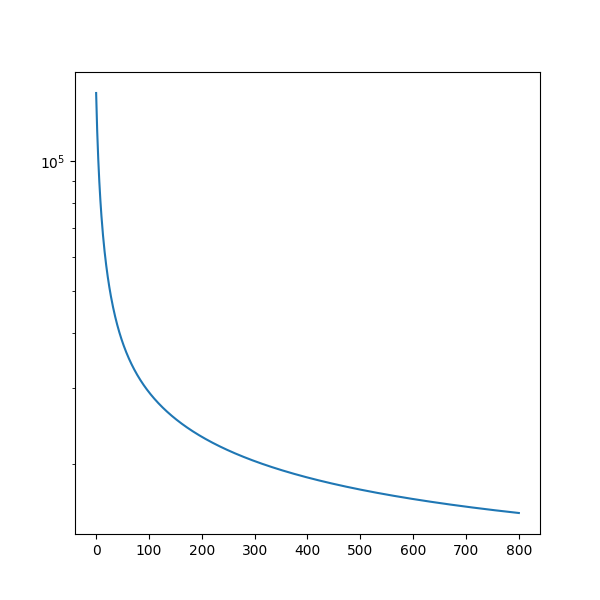

In [80]:
#plt.plot(np.log(emat['energy'][0]))
plt.figure()
plt.plot(emat['energy'][0])
plt.yscale('log')
plt.show()

# Look at atlas

In [81]:
atlas_tens_full = np.zeros((145,174,145,3,3))
atlas_tens_full[:,:,:,0,0] = atlas_tens[:,:,:,0]
atlas_tens_full[:,:,:,0,1] = atlas_tens[:,:,:,1]
atlas_tens_full[:,:,:,1,0] = atlas_tens[:,:,:,1]
atlas_tens_full[:,:,:,0,2] = atlas_tens[:,:,:,2]
atlas_tens_full[:,:,:,2,0] = atlas_tens[:,:,:,2]
atlas_tens_full[:,:,:,1,1] = atlas_tens[:,:,:,3]
atlas_tens_full[:,:,:,1,2] = atlas_tens[:,:,:,4]
atlas_tens_full[:,:,:,2,1] = atlas_tens[:,:,:,4]
atlas_tens_full[:,:,:,2,2] = atlas_tens[:,:,:,5]
itkview(atlas_tens_full[:,:,:,0,2], label_image=atlas_mask)


Viewer(geometries=[], gradient_opacity=0.22, interpolation=False, point_sets=[], rendered_image=<itk.itkImageP…

In [82]:
print(np.min(atlas_tens),np.max(atlas_tens))

-40.312058245864684 301.44537942718443


In [102]:
tidx=0
in_tens_full = np.zeros((145,174,145,3,3))
in_tens_full[:,:,:,0,0] = in_tensors[tidx][:,:,:,0]
in_tens_full[:,:,:,0,1] = in_tensors[tidx][:,:,:,1]
in_tens_full[:,:,:,1,0] = in_tensors[tidx][:,:,:,1]
in_tens_full[:,:,:,0,2] = in_tensors[tidx][:,:,:,2]
in_tens_full[:,:,:,2,0] = in_tensors[tidx][:,:,:,2]
in_tens_full[:,:,:,1,1] = in_tensors[tidx][:,:,:,3]
in_tens_full[:,:,:,1,2] = in_tensors[tidx][:,:,:,4]
in_tens_full[:,:,:,2,1] = in_tensors[tidx][:,:,:,4]
in_tens_full[:,:,:,2,2] = in_tensors[tidx][:,:,:,5]
#itkview(in_tens_full[:,:,:,0,2], label_image=out_masks[tidx])
itkview(in_tens_full[:,:,:,0,2], label_image=in_masks[tidx])

Viewer(geometries=[], gradient_opacity=0.22, interpolation=False, point_sets=[], rendered_image=<itk.itkImageP…

In [ ]:
wm_mask = np.zeros_like(in_masks[tidx])
wm_mask[in_masks[tidx] == 1] = 1
wm_diff = wm_mask[:,::-1,:] - out_masks[tidx]
itkview(out_masks[tidx],label_image=wm_mask[:,::-1,:])

# Look at atlas geodesics

In [18]:
%%time
all_atlas_start_coords = [[72,117,56],[72,118,56],[72,119,56],[72,120,56],[72,121,56],[72,122,56],[72,123,56],[79,124,56]]
atlas_geos = []
labels = []
atlas_tens_4_path = np.transpose(atlas_tens,(3,0,1,2))

geo_delta_t = 0.1#0.01#0.005
geo_iters = 3000 # 22000 for Kris annulus(delta_t=0.005), 32000 for cubic (delta_t=0.005)
euler_delta_t = 0.1
euler_iters = 4600 # 14600


for start_coords in all_atlas_start_coords:

  label = f'{start_coords}'
  labels.append(label)
  init_velocities = [None]

  # Compute paths for atlas tensors
  geox, geoy, geoz = geodesic.geodesicpath_3d(atlas_tens_4_path, atlas_mask,\
                                start_coords, init_velocities[0], \
                                geo_delta_t, iter_num=geo_iters, both_directions=True)

  atlas_geos.append((geox, geoy, geoz))
    

## Compute paths for atlas tensors
#geox, geoy, geoz = geodesic.batch_geodesicpath_3d(atlas_tens_4_path, atlas_mask,\
#                                all_atlas_start_coords, init_velocities[0], \
#                                geo_delta_t, iter_num=geo_iters, both_directions=True)

#for p in len(all_atlas_start_coords):
#  atlas_geos.append((geox[p], geoy[p], geoz[p]))

# numpy time: 7 min, 30s

LinAlgError: Eigenvalues did not converge

In [55]:
view_3d_paths(atlas_mask,
              paths=atlas_geos,
             labels=labels)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [12]:
%%time
# same as above but with torch
all_atlas_start_coords = [[72,117,56],[72,118,56],[72,119,56],[72,120,56],[72,121,56],[72,122,56],[72,123,56],[79,124,56]]
atlas_geos = []
labels = []
atlas_tens_4_path = np.transpose(atlas_tens,(3,0,1,2))

geo_delta_t = 0.1#0.01#0.005
geo_iters = 3000 # 22000 for Kris annulus(delta_t=0.005), 32000 for cubic (delta_t=0.005)
euler_delta_t = 0.1
euler_iters = 4600 # 14600


for start_coords in all_atlas_start_coords:

  label = f'{start_coords}'
  labels.append(label)
  init_velocities = [None]

  # Compute paths for atlas tensors
  geox, geoy, geoz = geodesic.geodesicpath_3d_torch(torch.from_numpy(atlas_tens_4_path), torch.from_numpy(atlas_mask),\
                                start_coords, init_velocities[0], \
                                geo_delta_t, iter_num=geo_iters, both_directions=True)

  atlas_geos.append((geox, geoy, geoz))

# torch CPU time:

Finding geodesic path from [72, 117, 56] with initial velocity [tensor(0.9686), tensor(-0.1525), tensor(0.1962)]
Found 921 voxels where unable to take 1st derivative.
Found 5065 reduced accuracy 2nd derivative voxels.


TypeError: can't assign a list to a torch.FloatTensor

In [13]:
%%time
# same as above but with torch
all_atlas_start_coords = [[72,117,56],[72,118,56],[72,119,56],[72,120,56],[72,121,56],[72,122,56],[72,123,56],[79,124,56]]
atlas_geos = []
labels = []
atlas_tens_4_path = np.transpose(atlas_tens,(3,0,1,2))

geo_delta_t = 0.1#0.01#0.005
geo_iters = 3000 # 22000 for Kris annulus(delta_t=0.005), 32000 for cubic (delta_t=0.005)
euler_delta_t = 0.1
euler_iters = 4600 # 14600


for start_coords in all_atlas_start_coords:

  label = f'{start_coords}'
  labels.append(label)
  init_velocities = [None]

  # Compute paths for atlas tensors
  geox, geoy, geoz = geodesic.geodesicpath_3d_torch(torch.from_numpy(atlas_tens_4_path).cuda(), torch.from_numpy(atlas_mask).cuda(),\
                                start_coords, init_velocities[0], \
                                geo_delta_t, iter_num=geo_iters, both_directions=True)

  atlas_geos.append((geox, geoy, geoz))

# torch GPU time:

Finding geodesic path from [72, 117, 56] with initial velocity [tensor(0.9686), tensor(-0.1525), tensor(0.1962)]
Found 921 voxels where unable to take 1st derivative.
Found 5065 reduced accuracy 2nd derivative voxels.


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [11]:
all_atlas_start_coords = []
xseedmin = 72
xseedmax = 79
yseedmin = 117
yseedmax = 124
zseedmin = 55
zseedmax = 60
for xx in np.linspace(xseedmin, xseedmax, num=5):
  for yy in np.linspace(yseedmin, yseedmax, num=5):
    for zz in np.linspace(zseedmin, zseedmax, num=5):
      if atlas_mask[math.floor(xx),math.floor(yy),math.floor(zz)] > 0.5:
        all_atlas_start_coords.append([xx,yy,zz])

In [12]:
%%time
compute_atlas_geos=False
if compute_atlas_geos:
  atlas_geos = []
  labels = []
  atlas_tens_4_path = np.transpose(atlas_tens,(3,0,1,2))

  geo_delta_t = 0.1#0.01#0.005
  geo_iters = 3000 # 22000 for Kris annulus(delta_t=0.005), 32000 for cubic (delta_t=0.005)
  euler_delta_t = 0.1
  euler_iters = 4600 # 14600


  for start_coords in all_atlas_start_coords:

    label = f'{start_coords}'
    labels.append(label)
    init_velocities = [None]

    # Compute paths for atlas tensors
    geox, geoy, geoz = geodesic.geodesicpath_3d(atlas_tens_4_path, atlas_mask,\
                                  start_coords, init_velocities[0], \
                                  geo_delta_t, iter_num=geo_iters, both_directions=True)

    atlas_geos.append((geox, geoy, geoz))
    pickle.dump(atlas_geos,open(f'{atlas_geo_dir}atlas_geos.pkl','wb'))
else:
    labels = []
    for start_coords in all_atlas_start_coords:
      label = f'{start_coords}'
      labels.append(label)
    atlas_geos=pickle.load(open(f'{atlas_geo_dir}atlas_geos.pkl','rb'))
    

CPU times: user 344 µs, sys: 4.16 ms, total: 4.5 ms
Wall time: 4.41 ms


In [13]:
t1_floats = []
for t1 in t1s:
  t1_float = np.zeros((t1.shape[0],t1.shape[1],t1.shape[2]),dtype='float32')
  t1_float[:] = t1[:]
  t1_floats.append(t1_float)

In [14]:
# Compute t1 mean using diffeos
t1_mean = np.zeros_like(t1_floats[0])
num_t1s = len(t1_floats)
for t1, phi_inv in zip(t1_floats, phi_invs):
  t1_atlas_space = compose_function(torch.from_numpy(t1), torch.from_numpy(phi_inv)).detach().numpy()
  t1_mean = t1_mean + t1_atlas_space

t1_mean = t1_mean / num_t1s

In [19]:
vwr=itkview(t1_mean[:,::-1,:])
vwr

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [20]:
start_camera = vwr.camera
#opac_gaussians = vwr.opacity_gaussians

In [15]:
#pickle.dump(opac_gaussians,open(f'{atlas_geo_dir}opacity_gaussians.pkl','wb'))
opac_gaussians = pickle.load(open(f'{atlas_geo_dir}opacity_gaussians.pkl','rb'))

In [16]:
def movie_3d_paths(img, paths=None, labels=None,cmap=None,rotate=False,camera=None,gradient_opacity=0.22,
                   sample_distance=0.25,
                   opacity_gaussians=None,xrng=None, yrng=None, zrng=None, viewer=None, 
                   num_tube_pts=500, tube_radius=0.5, colors=[]):
  if xrng is None:
    xrng = [0, img.shape[0]]
  if yrng is None:
    yrng = [0, img.shape[1]]
  if zrng is None:
    zrng = [0, img.shape[2]]
  if labels is None:
    labels = range(len(paths))

  #glyphs = []
  glyphs = {}
  if paths is not None:
    for p, label in zip(paths, labels):
      tube = path_to_tube(p[0], p[1], p[2], num_tube_pts, tube_radius)
      #glyphs.append(tube)
      glyphs[label] = tube

  if viewer:
    if img is not None:
      viewer.image = img[xrng[0]:xrng[1],yrng[0]:yrng[1],zrng[0]:zrng[1]]
      viewer.geometries = glyphs
  else:
    if img is not None:
      viewer = itkview(img[xrng[0]:xrng[1],yrng[0]:yrng[1],zrng[0]:zrng[1]],
                       geometries=glyphs, geometry_colors=colors, cmap=cmap, rotate=rotate, 
                       gradient_opacity=gradient_opacity, ui_collapsed=True, annotations=False,
                       sample_distance=sample_distance)
    else:
      viewer = itkview(geometries=glyphs, geometry_colors=colors, cmap=cmap, rotate=rotate, 
                       gradient_opacity=gradient_opacity, ui_collapsed=True, annotations=False,
                       sample_distance=sample_distance)
    
  if camera is not None:
    viewer.camera = camera

  if opacity_gaussians is not None:
    viewer.opacity_gaussians = opacity_gaussians
  return(viewer)



In [21]:

#vwr = view_3d_paths(t1_mean[:,::-1,:],
#              paths=atlas_geos[:75],
#             labels=labels[:75],
#             num_tube_pts = 50,
#             tube_radius = 0.1)

vwr = movie_3d_paths(t1_mean[:,::-1,:],
                     paths=atlas_geos[:75],
                     labels=labels[:75],
                     cmap='Grayscale',
                     rotate=False,
                     camera=start_camera,
                     gradient_opacity=0.97,
                     sample_distance=0.25,
                     opacity_gaussians=opac_gaussians,
                     num_tube_pts = 100,
                     tube_radius = 0.1)

In [69]:
geos_from_file = pickle.load(open('/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/IPMI2021Presentation/atlas_geos.pkl','rb'))

In [22]:
display(vwr)
#recorder = ipywebrtc.VideoRecorder(stream=vwr,
#    filename=f'{animation_dir}atlas_cc_3D.mp4',
#    autosave=True)
#recorder
#recorder.recording = True
#time.sleep(5)
#recorder.recording = False
#recorder.autosave = False
#recorder.save(f'{animation_dir}atlas_cc_3D.mp4')

Viewer(annotations=False, camera=array([[ 7.8480560e+01, -1.6702644e+01, -4.3374628e+02],
       [ 7.2000000e+…

In [67]:
recorder.recording = True
time.sleep(5)
recorder.recording = False
recorder.autosave = False
recorder.save(f'{animation_dir}atlas_cc_3D.mp4')

ValueError: No data, did you record anything?

In [41]:
vwr.sample_distance = 0.25

In [48]:
vwr.gradient_opacity=0.97

Help on Viewer in module itkwidgets.widget_viewer object:

class Viewer(ipywebrtc.webrtc.MediaStream)
 |  Viewer widget class.
 |  
 |  Method resolution order:
 |      Viewer
 |      ipywebrtc.webrtc.MediaStream
 |      ipywidgets.widgets.domwidget.DOMWidget
 |      ipywidgets.widgets.widget.Widget
 |      ipywidgets.widgets.widget.LoggingHasTraits
 |      traitlets.traitlets.HasTraits
 |      traitlets.traitlets.HasDescriptors
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, **kwargs)
 |      Public constructor
 |  
 |  roi_region(self)
 |      Return the itk.ImageRegion corresponding to the roi.
 |  
 |  roi_slice(self)
 |      Return the numpy array slice corresponding to the roi.
 |  
 |  update_rendered_image(self, change=None)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  annotations
 |      A casting version of the boolean trait.
 |  
 |  axes
 |      A casting version of

In [42]:
atlas_full = np.zeros((atlas_tens.shape[0],atlas_tens.shape[1],atlas_tens.shape[2],3,3))
atlas_full[:,:,:,0,0] = atlas_tens[:,:,:,0]
atlas_full[:,:,:,0,1] = atlas_tens[:,:,:,1]
atlas_full[:,:,:,1,0] = atlas_tens[:,:,:,1]
atlas_full[:,:,:,0,2] = atlas_tens[:,:,:,2]
atlas_full[:,:,:,2,0] = atlas_tens[:,:,:,2]
atlas_full[:,:,:,1,1] = atlas_tens[:,:,:,3]
atlas_full[:,:,:,1,2] = atlas_tens[:,:,:,4]
atlas_full[:,:,:,2,1] = atlas_tens[:,:,:,4]
atlas_full[:,:,:,2,2] = atlas_tens[:,:,:,5]


In [46]:
zviewer = TensorZViewer(atlas_full, 
                        atlas_mask, paths=atlas_geos, zslice=56, stride=5, scale=3)

#sliders = interactive(zviewer.set_vals,
#                      zslice=(0,atlas_tens.shape[2],1),
#                      stride=(3,8,1),scale=(0.1,10,.1),
#                      continuous_update=False)
#ipywidgets.VBox([zviewer.vwr, sliders])
zviewer.vwr

In [32]:
np.min(zviewer.vwr.geometry_colors)

0.00025650513

# View Alphas

In [16]:
print(len(cases))
for idx in range(len(cases)):
  print(idx,cases[idx])

33
0 106824
1 102715
2 107422
3 100206
4 104416
5 107725
6 106521
7 102008
8 108323
9 108525
10 102311
11 108222
12 109123
13 103212
14 102614
15 103515
16 105216
17 100610
18 104820
19 102513
20 105923
21 104012
22 105620
23 106319
24 101410
25 103010
26 107321
27 109830
28 102816
29 102109
30 108020
31 101006
32 107018


In [24]:
subj_idx=20
run_case = cases[subj_idx]
print(run_case)

view_alpha=True

if view_alpha:
  result = loadmat(f'{outroot}/{run_case}_results.mat')
  out_mask = result["filt_mask"]
  alpha = result["alpha"]
  vv=itkview(alpha,label_image=out_mask)
else:
  t1 = ReadScalars(inroot+run_case+'/T1w_acpc_dc_restore_1.25.nii.gz')
  fa = ReadScalars(inroot+run_case+'/dti_3000_FA.nii.gz')

  #itkview(t1s[subj_idx][:,::-1,:],label_image=in_masks[subj_idx])
  vv=itkview(fa,label_image=in_masks[subj_idx])
  #itkview(t1,label_image=mask)
vv

105923


Viewer(geometries=[], gradient_opacity=0.22, interpolation=False, point_sets=[], rendered_image=<itk.itkImageP…

In [15]:
new_mask = np.zeros_like(fa)
new_mask[fa > 0.1] = 1

In [16]:
itkview(fa,label_image=new_mask)

Viewer(geometries=[], gradient_opacity=0.22, interpolation=False, point_sets=[], rendered_image=<itk.itkImageP…

In [25]:
itkview(out_mask, label_image=in_masks[subj_idx])

Viewer(geometries=[], gradient_opacity=0.22, interpolation=False, point_sets=[], rendered_image=<itk.itkImageP…

# Check orig mask

In [10]:
orig_mask = ReadScalars('/usr/sci/projects/HCP/Kris/NSFCRCNS/prepped_UKF_data_with_grad_dev/105923/dti_1000_FA_mask.nhdr')
dir_mask = ReadScalars('/usr/sci/projects/HCP/Kris/NSFCRCNS/prepped_UKF_data_with_grad_dev/105923/dti_1000_FA_mask_directions.nhdr')
itkview(orig_mask,label_image=dir_mask)


Viewer(geometries=[], gradient_opacity=0.22, interpolation=False, point_sets=[], rendered_image=<itk.itkImageP…

In [12]:
np.min(orig_mask-dir_mask)

0.0

# Look at scaled_orig_tensors.   How to preprocess to avoid cholesky singularization issues?

In [24]:
def get_framework(arr):
  # return np or torch depending on type of array
  # also returns framework name as "numpy" or "torch"
  fw = None
  fw_name = ''
  if type(arr) == np.ndarray:
    fw = np
    fw_name = 'numpy'
  else:
    fw = torch
    fw_name = 'torch'
  return (fw, fw_name)

#def make_pos_def(tens, mask, small_eval = 0.00005):
#  print('mod make_pos_def')
#  # make any small or negative eigenvalues slightly positive and then reconstruct tensors
#  fw, fw_name = get_framework(tens)
#  if fw_name == 'numpy':
#    evals, evecs = np.linalg.eig(tens)
#  else:
#    evals, evecs = torch.symeig(tens,eigenvectors=True)
#  #cmplx_evals, cmplx_evecs = fw.linalg.eig(tens)
#  #evals = fw.real(cmplx_evals)
#  #evecs = fw.real(cmplx_evecs)
#  #np.abs(evals, out=evals)
#  idx = fw.where(evals < small_eval)
#  #idx = np.where(evals < 0)
#  num_found = 0
#  #print(len(idx[0]), 'tensors found with eigenvalues <', small_eval)
#  for ee in range(len(idx[0])):
#    if mask[idx[0][ee], idx[1][ee], idx[2][ee]]:
#      num_found += 1
#      # If largest eigenvalue is negative, replace with identity
#      eval_2 = (idx[3][ee]+1) % 3
#      eval_3 = (idx[3][ee]+2) % 3
#      if ((evals[idx[0][ee], idx[1][ee], idx[2][ee], eval_2] < 0) and 
#         (evals[idx[0][ee], idx[1][ee], idx[2][ee], eval_3] < 0)):
#        evecs[idx[0][ee], idx[1][ee], idx[2][ee]] = fw.eye(3, dtype=tens.dtype)
#        evals[idx[0][ee], idx[1][ee], idx[2][ee], idx[3][ee]] = small_eval
#        #evals[idx[0][ee], idx[1][ee], idx[2][ee], eval_2] = small_eval
#        #evals[idx[0][ee], idx[1][ee], idx[2][ee], eval_3] = small_eval
#      else:
#        # otherwise just set this eigenvalue to small_eval
#        evals[idx[0][ee], idx[1][ee], idx[2][ee], idx[3][ee]] = small_eval

#  print(num_found, 'tensors found with eigenvalues <', small_eval)
#  #print(num_found, 'tensors found with eigenvalues < 0')
#  mod_tens = fw.einsum('...ij,...jk,...k,...lk->...il',
#                       evecs, fw.eye(3, dtype=tens.dtype), evals, evecs)
#  #mod_tens = fw.einsum('...ij,...j,...jk->...ik',
#  #                     evecs, evals, evecs)
#  return(mod_tens)

def make_pos_def(tens, mask, small_eval = 0.00005):
  # make any small or negative eigenvalues slightly positive and then reconstruct tensors
  
  fw, fw_name = get_framework(tens)
  if fw_name == 'numpy':
    sym_tens = (tens + tens.transpose(0,1,2,4,3))/2
    evals, evecs = np.linalg.eig(sym_tens)
  else:
    sym_tens = (tens + torch.transpose(tens,3,4))/2
    evals, evecs = torch.symeig(sym_tens,eigenvectors=True)
  #cmplx_evals, cmplx_evecs = fw.linalg.eig(sym_tens)
  #evals = fw.real(cmplx_evals)
  #evecs = fw.real(cmplx_evecs)
  #np.abs(evals, out=evals)
  idx = fw.where(evals < small_eval)
  #idx = np.where(evals < 0)
  num_found = 0
  #print(len(idx[0]), 'tensors found with eigenvalues <', small_eval)
  for ee in range(len(idx[0])):
    if mask[idx[0][ee], idx[1][ee], idx[2][ee]]:
      num_found += 1
      # If largest eigenvalue is negative, replace with identity
      eval_2 = (idx[3][ee]+1) % 3
      eval_3 = (idx[3][ee]+2) % 3
      if ((evals[idx[0][ee], idx[1][ee], idx[2][ee], eval_2] < 0) and 
         (evals[idx[0][ee], idx[1][ee], idx[2][ee], eval_3] < 0)):
        evecs[idx[0][ee], idx[1][ee], idx[2][ee]] = fw.eye(3, dtype=tens.dtype)
        evals[idx[0][ee], idx[1][ee], idx[2][ee], idx[3][ee]] = small_eval
      else:
        # otherwise just set this eigenvalue to small_eval
        evals[idx[0][ee], idx[1][ee], idx[2][ee], idx[3][ee]] = small_eval

  print(num_found, 'tensors found with eigenvalues <', small_eval)
  #print(num_found, 'tensors found with eigenvalues < 0')
  mod_tens = fw.einsum('...ij,...jk,...k,...lk->...il',
                       evecs, fw.eye(3, dtype=tens.dtype), evals, evecs)
  #mod_tens = fw.einsum('...ij,...j,...jk->...ik',
  #                     evecs, evals, evecs)

  chol = batch_cholesky_v2(mod_tens)
  idx = fw.where(fw.isnan(chol))
  iso_tens = small_eval * fw.eye((3))
  for pt in range(len(idx[0])):
    mod_tens[idx[0][pt],idx[1][pt],idx[2][pt]] = iso_tens

  if fw_name == 'numpy':
    mod_sym_tens = (mod_tens + mod_tens.transpose(0,1,2,4,3))/2
  else:
    mod_sym_tens = (mod_tens + torch.transpose(mod_tens,3,4))/2

  return(mod_sym_tens)

def batch_cholesky(tens):
  # from https://stackoverflow.com/questions/60230464/pytorch-torch-cholesky-ignoring-exception
  # will get NaNs instead of exception where cholesky is invalid
  fw, fw_name = get_framework(tens)
  L = fw.zeros_like(tens)

  for i in range(tens.shape[-1]):
    for j in range(i+1):
      s = 0.0
      for k in range(j):
        s = s + L[...,i,k] * L[...,j,k]

      L[...,i,j] = fw.sqrt(tens[...,i,i] - s) if (i == j) else \
                      (1.0 / L[...,j,j] * (tens[...,i,j] - s))
  return L

def batch_cholesky_v2(tens):
  fw, fw_name = get_framework(tens)
  if fw_name == 'numpy':
    nan = fw.nan
  else:
    nan = fw.tensor(float('nan'))
  L = fw.zeros_like(tens)
  for xx in range(tens.shape[0]):
    for yy in range(tens.shape[1]):
      for zz in range(tens.shape[2]):
        try:
          L[xx,yy,zz] = fw.linalg.cholesky(tens[xx,yy,zz])
        except:
          L[xx,yy,zz] = nan * fw.ones((tens.shape[-2:]))
  return L


In [9]:
#tens = ReadTensors('/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/MELBAResults/atlases/BrainAtlasUkfB1000Aug17/105923_scaled_orig_tensors_atlas_space.nhdr')
#tens = ReadTensors('/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/UKF_experiments/B1000Results/105923_scaled_orig_tensors.nhdr')
#orig_mask = ReadScalars('/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/UKF_experiments/B1000Results/105923_orig_mask.nhdr')
tens = ReadTensors('/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/UKF_experiments/BallResults/105923_scaled_unsmoothed_tensors.nhdr')
orig_mask = ReadScalars('/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/UKF_experiments/BallResults/105923_orig_mask.nhdr')
filt_mask = ReadScalars('/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/UKF_experiments/BallResults/105923_filt_mask.nhdr')
tens_full = tens_6_to_tens_3x3(tens)
tens_inv = np.linalg.inv(tens_full)
det_tens = np.linalg.det(tens_inv)

In [23]:
torch.linalg.cholesky(torch.from_numpy(tens_inv[30,30,30]))

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], dtype=torch.float64)

In [25]:
chol = batch_cholesky_v2(tens_inv)
chol_mask = np.zeros((tens_inv.shape[0],tens_inv.shape[1],tens_inv.shape[2]))
#chol_mask = np.sum(np.isnan(chol),-1)
idx = np.where(np.isnan(chol))
#print(idx.shape, idx[0].shape)
iso_tens = np.eye((3))
#print(np.max(tens_inv))
for pt in range(len(idx[0])):
  #chol_mask[idx[0][pt],idx[1][pt],idx[2][pt]] = 1
  tens_inv[idx[0][pt],idx[1][pt],idx[2][pt]] = iso_tens
chol_mask[idx[0],idx[1],idx[2]] = 1

In [26]:
itkview(orig_mask, label_image = chol_mask)

Viewer(geometries=[], gradient_opacity=0.22, interpolation=False, point_sets=[], rendered_image=<itk.itkImageP…

In [27]:
chol2 = batch_cholesky_v2(torch.from_numpy(tens_inv))
chol2_mask = torch.zeros((tens_inv.shape[0],tens_inv.shape[1],tens_inv.shape[2]))
#chol_mask = np.sum(np.isnan(chol),-1)
idx = torch.where(torch.isnan(chol2))
#print(idx.shape, idx[0].shape)
iso_tens = np.eye((3))
#print(np.max(tens_inv))
for pt in range(len(idx[0])):
  #chol_mask[idx[0][pt],idx[1][pt],idx[2][pt]] = 1
  tens_inv[idx[0][pt],idx[1][pt],idx[2][pt]] = iso_tens
chol2_mask[idx[0],idx[1],idx[2]] = 1

In [28]:
itkview(orig_mask, label_image = chol2_mask.detach().numpy())

Viewer(geometries=[], gradient_opacity=0.22, interpolation=False, point_sets=[], rendered_image=<itk.itkImageP…

In [121]:
G=np.linalg.cholesky(tens_inv)

In [11]:
print(np.min(det_tens),np.max(det_tens))
fore_back_adaptor = np.where(np.linalg.det(tens_inv)>1e2, 1e-3, 1.)
metric = np.einsum('ijk...,lijk->ijk...', tens_inv, np.expand_dims(fore_back_adaptor,0))
det_met = np.linalg.det(metric)
print(np.min(det_met),np.max(det_met))

-6242085202490460.0 3098597354942991.5
-6242085202490460.0 3098597.3549360805


In [32]:
itkview(det_met)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [22]:
print(np.where(np.linalg.eigvals(metpsd2) < 0))


(array([ 23,  36,  49,  60,  74,  93,  95, 100, 101, 101]), array([ 77,  64, 142, 112, 120,  51, 121,  88, 107, 119]), array([83, 19, 83, 31, 39, 11, 99, 25, 22, 96]), array([2, 2, 0, 2, 0, 0, 0, 2, 0, 2]))


In [43]:
for xx in range(metric.shape[0]):
    for yy in range(metric.shape[1]):
        for zz in range(metric.shape[2]):
            if np.allclose(metric[xx,yy,zz], metric[xx,yy,zz].T):
                pass
            else:
                print(xx,yy,zz)

KeyboardInterrupt: 

In [63]:
metpsd = make_pos_def(metric,np.ones((145,174,145)))

mod make_pos_def
25069 tensors found with eigenvalues < 5e-05


In [64]:
evals = np.linalg.eigvals(metric)
evalpsd = np.linalg.eigvals(metpsd)

In [65]:
print(metric[22,52,57])
print(evals[22,52,57])
print(metpsd[22,52,57])
print(np.real(evalpsd[22,52,57]))

[[  3445.11846975   -454.32625774   1973.1315052 ]
 [  -454.32625774 -29006.97280731 -22080.30515273]
 [  1973.1315052  -22080.30515273  -4663.36550021]]
[  2787.20959592   9043.93769426 -42056.36712794]
[[ 3452.75604043  -942.12663887  1684.68578727]
 [ -942.12663887  2148.11852503 -3657.70231283]
 [ 1684.68578727 -3657.70231283  6230.27277472]]
[9.04393769e+03 2.78720960e+03 4.99999992e-05]


In [85]:
print(metric[23,77,83])
print(evals[23,77,83])
print(metpsd[23,77,83])
print(np.real(evalpsd[23,77,83]))
print(metpsd2[23,77,83])
print(np.linalg.eigvals(metpsd2[23,77,83]))

[[-1186.84903408 -2082.87295536 -1083.02371714]
 [-2082.87295536 -4089.27395406 -1859.57564929]
 [-1083.02371714 -1859.57564929 -1319.41059418]]
[-6136.31002799   -70.68419624  -388.53935808]
[[5.e-05 0.e+00 0.e+00]
 [0.e+00 5.e-05 0.e+00]
 [0.e+00 0.e+00 5.e-05]]
[5.e-05 5.e-05 5.e-05]
[[5.e-05+0.j 0.e+00+0.j 0.e+00+0.j]
 [0.e+00+0.j 5.e-05+0.j 0.e+00+0.j]
 [0.e+00+0.j 0.e+00+0.j 5.e-05+0.j]]
[5.e-05+0.j 5.e-05+0.j 5.e-05+0.j]


In [51]:
print(metric[23,77,83])
print(evals[23,77,83])
print(metpsd[23,77,83])
print(np.real(evalpsd[23,77,83]))
print(metpsd2[23,77,83])
print(np.linalg.eigvals(metpsd2[23,77,83]))

[[-1186.84903408 -2082.87295536 -1083.02371714]
 [-2082.87295536 -4089.27395406 -1859.57564929]
 [-1083.02371714 -1859.57564929 -1319.41059418]]
[-6136.31002799   -70.68419624  -388.53935808]
[[5.e-05 0.e+00 0.e+00]
 [0.e+00 5.e-05 0.e+00]
 [0.e+00 0.e+00 5.e-05]]
[5.e-05 5.e-05 5.e-05]
[[5.e-05 0.e+00 0.e+00]
 [0.e+00 5.e-05 0.e+00]
 [0.e+00 0.e+00 5.e-05]]
[5.e-05 5.e-05 5.e-05]


In [68]:
print(metric[23,75,40])
print(evals[23,75,40])
print(metpsd[23,75,40])
print(np.real(evalpsd[23,75,40]))
print(metpsd2[23,75,40])
print(np.linalg.eigvals(metpsd2[23,75,40]))

[[-20314.18393125  12880.3838426  -26494.94557993]
 [ 12880.3838426   -2502.90656243  13982.88688372]
 [-26494.94557993  13982.88688372 -26621.09236831]]
[-56803.62167818   3111.75603902   4253.68277717]
[[ 2098.31847693  1091.34883361 -1359.12058579]
 [ 1091.34883361  3698.15675089   761.37705679]
 [-1359.12058579   761.37705679  1568.96363837]]
[4.99999992e-05 3.11175604e+03 4.25368278e+03]
[[ 2098.3186   1091.3488  -1359.1206 ]
 [ 1091.3488   3698.1565    761.37714]
 [-1359.1207    761.37714  1568.9637 ]]
[4.9154085e-05 3.1117563e+03 4.2536826e+03]


In [76]:
sym = (metpsd2[23,75,40].T + metpsd2[23,75,40])/2.0
inv = np.linalg.inv(sym)
print(sym,inv)
print(np.matmul(inv.T, sym))

[[ 2098.3186   1091.3488  -1359.1206 ]
 [ 1091.3488   3698.1565    761.37714]
 [-1359.1206    761.37714  1568.9637 ]] [[ 3824.3538 -2011.6201  4289.0474]
 [-2011.6201  1058.1178 -2256.0503]
 [ 4289.0474 -2256.0503  4810.2056]]
[[1.    0.25  0.5  ]
 [0.    1.125 0.   ]
 [0.5   0.    0.5  ]]


In [54]:
np.linalg.cholesky(metpsd2[23,75,40])

LinAlgError: Matrix is not positive definite

In [59]:
det_psd = np.linalg.det(metpsd)
print(np.min(det_psd),np.max(det_psd))

1.2499999999999942e-13 354240214.57669


In [79]:
G=np.linalg.cholesky(metpsd)

In [122]:
torch.set_default_tensor_type('torch.cuda.DoubleTensor')
mettorch = torch.from_numpy(metpsd)
size = mettorch.size()
print('update_karcher_mean, size:', size)
mettorch2 = mettorch.reshape(-1, *size[-2:])  # (-1,3,3)
gm = mettorch2
retval = gm.reshape(*size[:])
metdiff = metpsd - retval.detach().numpy() # nonzero
#metdiff = (mettorch - retval).detach().numpy() # 0
#metdiff = metpsd - torch.from_numpy(metpsd).detach().numpy()
print(np.min(metdiff),np.max(metdiff))
#print(torch.min(metdiff),torch.max(metdiff))

update_karcher_mean, size: torch.Size([145, 174, 145, 3, 3])
0.0 0.0


In [15]:
G=np.linalg.cholesky(gm.reshape(*size[:]))

LinAlgError: Matrix is not positive definite

In [82]:
metpsd2 = make_pos_def(retval.detach().numpy(),np.ones((145,174,145)))

mod make_pos_def
10467 tensors found with eigenvalues < 5e-05


In [67]:
for xx in range(145):
    for yy in range(174):
        for zz in range(145):
            try:
                G = np.linalg.cholesky(metpsd2[xx,yy,zz])
            except Exception as err:
                print('Caught',err, 'for point',xx,yy,zz)

Caught Matrix is not positive definite for point 17 69 54
Caught Matrix is not positive definite for point 17 69 55
Caught Matrix is not positive definite for point 17 70 56
Caught Matrix is not positive definite for point 18 69 56
Caught Matrix is not positive definite for point 19 84 61
Caught Matrix is not positive definite for point 21 53 63
Caught Matrix is not positive definite for point 21 57 56
Caught Matrix is not positive definite for point 21 90 79
Caught Matrix is not positive definite for point 23 51 73
Caught Matrix is not positive definite for point 23 75 39
Caught Matrix is not positive definite for point 23 75 40
Caught Matrix is not positive definite for point 23 102 72
Caught Matrix is not positive definite for point 23 102 74
Caught Matrix is not positive definite for point 23 103 71
Caught Matrix is not positive definite for point 23 103 72
Caught Matrix is not positive definite for point 23 103 73
Caught Matrix is not positive definite for point 23 103 74
Caught M

Caught Matrix is not positive definite for point 34 94 26
Caught Matrix is not positive definite for point 34 95 26
Caught Matrix is not positive definite for point 35 38 78
Caught Matrix is not positive definite for point 35 38 79
Caught Matrix is not positive definite for point 35 38 80
Caught Matrix is not positive definite for point 35 38 81
Caught Matrix is not positive definite for point 35 46 28
Caught Matrix is not positive definite for point 35 47 28
Caught Matrix is not positive definite for point 35 48 28
Caught Matrix is not positive definite for point 35 51 41
Caught Matrix is not positive definite for point 35 65 15
Caught Matrix is not positive definite for point 35 65 98
Caught Matrix is not positive definite for point 35 66 14
Caught Matrix is not positive definite for point 35 66 15
Caught Matrix is not positive definite for point 35 66 20
Caught Matrix is not positive definite for point 35 66 97
Caught Matrix is not positive definite for point 35 67 17
Caught Matrix 

Caught Matrix is not positive definite for point 42 106 23
Caught Matrix is not positive definite for point 42 107 23
Caught Matrix is not positive definite for point 42 117 97
Caught Matrix is not positive definite for point 42 135 85
Caught Matrix is not positive definite for point 42 144 73
Caught Matrix is not positive definite for point 43 29 76
Caught Matrix is not positive definite for point 43 32 46
Caught Matrix is not positive definite for point 43 33 79
Caught Matrix is not positive definite for point 43 34 82
Caught Matrix is not positive definite for point 43 35 85
Caught Matrix is not positive definite for point 43 39 88
Caught Matrix is not positive definite for point 43 45 97
Caught Matrix is not positive definite for point 43 46 98
Caught Matrix is not positive definite for point 43 80 34
Caught Matrix is not positive definite for point 43 81 33
Caught Matrix is not positive definite for point 43 81 34
Caught Matrix is not positive definite for point 43 88 24
Caught Ma

Caught Matrix is not positive definite for point 50 95 22
Caught Matrix is not positive definite for point 50 95 23
Caught Matrix is not positive definite for point 50 96 22
Caught Matrix is not positive definite for point 50 101 22
Caught Matrix is not positive definite for point 50 103 20
Caught Matrix is not positive definite for point 50 103 21
Caught Matrix is not positive definite for point 50 106 21
Caught Matrix is not positive definite for point 51 22 66
Caught Matrix is not positive definite for point 51 22 68
Caught Matrix is not positive definite for point 51 23 53
Caught Matrix is not positive definite for point 51 23 67
Caught Matrix is not positive definite for point 51 26 78
Caught Matrix is not positive definite for point 51 26 79
Caught Matrix is not positive definite for point 51 36 25
Caught Matrix is not positive definite for point 51 39 21
Caught Matrix is not positive definite for point 51 42 19
Caught Matrix is not positive definite for point 51 62 14
Caught Mat

Caught Matrix is not positive definite for point 58 138 92
Caught Matrix is not positive definite for point 58 138 93
Caught Matrix is not positive definite for point 58 143 42
Caught Matrix is not positive definite for point 58 157 50
Caught Matrix is not positive definite for point 58 158 59
Caught Matrix is not positive definite for point 59 19 63
Caught Matrix is not positive definite for point 59 23 46
Caught Matrix is not positive definite for point 59 24 44
Caught Matrix is not positive definite for point 59 24 45
Caught Matrix is not positive definite for point 59 25 44
Caught Matrix is not positive definite for point 59 31 32
Caught Matrix is not positive definite for point 59 32 30
Caught Matrix is not positive definite for point 59 32 32
Caught Matrix is not positive definite for point 59 35 25
Caught Matrix is not positive definite for point 59 36 23
Caught Matrix is not positive definite for point 59 49 14
Caught Matrix is not positive definite for point 59 56 13
Caught Ma

Caught Matrix is not positive definite for point 71 19 59
Caught Matrix is not positive definite for point 71 19 60
Caught Matrix is not positive definite for point 71 20 65
Caught Matrix is not positive definite for point 71 20 67
Caught Matrix is not positive definite for point 71 20 68
Caught Matrix is not positive definite for point 71 21 51
Caught Matrix is not positive definite for point 71 23 72
Caught Matrix is not positive definite for point 71 28 40
Caught Matrix is not positive definite for point 71 31 40
Caught Matrix is not positive definite for point 71 35 32
Caught Matrix is not positive definite for point 71 53 17
Caught Matrix is not positive definite for point 71 56 62
Caught Matrix is not positive definite for point 71 66 65
Caught Matrix is not positive definite for point 71 67 63
Caught Matrix is not positive definite for point 71 67 72
Caught Matrix is not positive definite for point 71 107 42
Caught Matrix is not positive definite for point 71 109 41
Caught Matri

Caught Matrix is not positive definite for point 78 117 38
Caught Matrix is not positive definite for point 78 117 39
Caught Matrix is not positive definite for point 78 121 39
Caught Matrix is not positive definite for point 78 122 39
Caught Matrix is not positive definite for point 78 140 43
Caught Matrix is not positive definite for point 78 156 51
Caught Matrix is not positive definite for point 79 18 57
Caught Matrix is not positive definite for point 79 19 72
Caught Matrix is not positive definite for point 79 20 45
Caught Matrix is not positive definite for point 79 21 41
Caught Matrix is not positive definite for point 79 21 74
Caught Matrix is not positive definite for point 79 25 41
Caught Matrix is not positive definite for point 79 29 39
Caught Matrix is not positive definite for point 79 30 39
Caught Matrix is not positive definite for point 79 35 24
Caught Matrix is not positive definite for point 79 70 69
Caught Matrix is not positive definite for point 79 72 70
Caught M

Caught Matrix is not positive definite for point 84 154 43
Caught Matrix is not positive definite for point 84 155 45
Caught Matrix is not positive definite for point 85 18 47
Caught Matrix is not positive definite for point 85 18 65
Caught Matrix is not positive definite for point 85 19 47
Caught Matrix is not positive definite for point 85 19 68
Caught Matrix is not positive definite for point 85 20 71
Caught Matrix is not positive definite for point 85 21 71
Caught Matrix is not positive definite for point 85 22 41
Caught Matrix is not positive definite for point 85 22 74
Caught Matrix is not positive definite for point 85 28 39
Caught Matrix is not positive definite for point 85 35 26
Caught Matrix is not positive definite for point 85 40 94
Caught Matrix is not positive definite for point 85 42 18
Caught Matrix is not positive definite for point 85 43 18
Caught Matrix is not positive definite for point 85 46 14
Caught Matrix is not positive definite for point 85 52 13
Caught Matri

Caught Matrix is not positive definite for point 89 70 15
Caught Matrix is not positive definite for point 89 110 20
Caught Matrix is not positive definite for point 89 110 21
Caught Matrix is not positive definite for point 89 122 39
Caught Matrix is not positive definite for point 89 122 40
Caught Matrix is not positive definite for point 89 134 94
Caught Matrix is not positive definite for point 89 142 45
Caught Matrix is not positive definite for point 89 145 47
Caught Matrix is not positive definite for point 89 145 84
Caught Matrix is not positive definite for point 89 147 46
Caught Matrix is not positive definite for point 89 154 48
Caught Matrix is not positive definite for point 90 20 49
Caught Matrix is not positive definite for point 90 21 49
Caught Matrix is not positive definite for point 90 21 67
Caught Matrix is not positive definite for point 90 26 73
Caught Matrix is not positive definite for point 90 26 74
Caught Matrix is not positive definite for point 90 34 27
Caug

Caught Matrix is not positive definite for point 95 88 24
Caught Matrix is not positive definite for point 95 112 23
Caught Matrix is not positive definite for point 95 119 29
Caught Matrix is not positive definite for point 95 149 48
Caught Matrix is not positive definite for point 95 151 47
Caught Matrix is not positive definite for point 95 153 49
Caught Matrix is not positive definite for point 96 24 52
Caught Matrix is not positive definite for point 96 24 62
Caught Matrix is not positive definite for point 96 29 43
Caught Matrix is not positive definite for point 96 31 42
Caught Matrix is not positive definite for point 96 32 40
Caught Matrix is not positive definite for point 96 34 78
Caught Matrix is not positive definite for point 96 35 36
Caught Matrix is not positive definite for point 96 35 37
Caught Matrix is not positive definite for point 96 65 13
Caught Matrix is not positive definite for point 96 66 11
Caught Matrix is not positive definite for point 96 73 15
Caught Ma

Caught Matrix is not positive definite for point 101 134 41
Caught Matrix is not positive definite for point 101 136 85
Caught Matrix is not positive definite for point 101 142 43
Caught Matrix is not positive definite for point 101 142 44
Caught Matrix is not positive definite for point 102 29 59
Caught Matrix is not positive definite for point 102 30 50
Caught Matrix is not positive definite for point 102 30 60
Caught Matrix is not positive definite for point 102 31 51
Caught Matrix is not positive definite for point 102 33 48
Caught Matrix is not positive definite for point 102 33 49
Caught Matrix is not positive definite for point 102 38 81
Caught Matrix is not positive definite for point 102 39 39
Caught Matrix is not positive definite for point 102 43 22
Caught Matrix is not positive definite for point 102 54 99
Caught Matrix is not positive definite for point 102 68 13
Caught Matrix is not positive definite for point 102 75 18
Caught Matrix is not positive definite for point 102

Caught Matrix is not positive definite for point 106 102 20
Caught Matrix is not positive definite for point 106 110 23
Caught Matrix is not positive definite for point 106 111 24
Caught Matrix is not positive definite for point 106 136 42
Caught Matrix is not positive definite for point 106 136 77
Caught Matrix is not positive definite for point 106 136 78
Caught Matrix is not positive definite for point 107 32 61
Caught Matrix is not positive definite for point 107 32 63
Caught Matrix is not positive definite for point 107 33 57
Caught Matrix is not positive definite for point 107 33 63
Caught Matrix is not positive definite for point 107 33 64
Caught Matrix is not positive definite for point 107 34 72
Caught Matrix is not positive definite for point 107 35 71
Caught Matrix is not positive definite for point 107 36 74
Caught Matrix is not positive definite for point 107 39 43
Caught Matrix is not positive definite for point 107 39 45
Caught Matrix is not positive definite for point 1

Caught Matrix is not positive definite for point 111 90 24
Caught Matrix is not positive definite for point 111 123 45
Caught Matrix is not positive definite for point 111 134 61
Caught Matrix is not positive definite for point 112 41 68
Caught Matrix is not positive definite for point 112 41 73
Caught Matrix is not positive definite for point 112 41 75
Caught Matrix is not positive definite for point 112 42 75
Caught Matrix is not positive definite for point 112 43 67
Caught Matrix is not positive definite for point 112 43 74
Caught Matrix is not positive definite for point 112 44 78
Caught Matrix is not positive definite for point 112 46 43
Caught Matrix is not positive definite for point 112 47 32
Caught Matrix is not positive definite for point 112 47 33
Caught Matrix is not positive definite for point 112 47 34
Caught Matrix is not positive definite for point 112 48 35
Caught Matrix is not positive definite for point 112 48 40
Caught Matrix is not positive definite for point 112 4

Caught Matrix is not positive definite for point 117 97 87
Caught Matrix is not positive definite for point 117 107 43
Caught Matrix is not positive definite for point 118 49 66
Caught Matrix is not positive definite for point 118 49 70
Caught Matrix is not positive definite for point 118 51 60
Caught Matrix is not positive definite for point 118 51 77
Caught Matrix is not positive definite for point 118 52 78
Caught Matrix is not positive definite for point 118 53 79
Caught Matrix is not positive definite for point 118 55 75
Caught Matrix is not positive definite for point 118 56 76
Caught Matrix is not positive definite for point 118 57 34
Caught Matrix is not positive definite for point 118 57 84
Caught Matrix is not positive definite for point 118 58 82
Caught Matrix is not positive definite for point 118 58 85
Caught Matrix is not positive definite for point 118 61 34
Caught Matrix is not positive definite for point 118 63 26
Caught Matrix is not positive definite for point 118 63

Caught Matrix is not positive definite for point 124 58 65
Caught Matrix is not positive definite for point 124 64 72
Caught Matrix is not positive definite for point 124 85 58
Caught Matrix is not positive definite for point 124 85 59
Caught Matrix is not positive definite for point 125 60 61
Caught Matrix is not positive definite for point 125 63 71
Caught Matrix is not positive definite for point 125 63 73
Caught Matrix is not positive definite for point 125 78 67
Caught Matrix is not positive definite for point 125 79 62
Caught Matrix is not positive definite for point 125 81 63
Caught Matrix is not positive definite for point 125 82 60
Caught Matrix is not positive definite for point 125 82 61
Caught Matrix is not positive definite for point 125 82 63
Caught Matrix is not positive definite for point 125 85 60
Caught Matrix is not positive definite for point 125 86 51
Caught Matrix is not positive definite for point 125 86 62
Caught Matrix is not positive definite for point 126 82 

In [123]:
G=np.linalg.cholesky(retval.detach().numpy())

In [12]:
bs_mask = ReadScalars('/usr/sci/projects/HCP/Kris/NSFCRCNS/prepped_UKF_data_with_grad_dev/108222/t1_brainseg_mask_orig_space.nhdr')
labels = ReadScalars('/usr/sci/projects/HCP/Kris/NSFCRCNS/prepped_UKF_data_with_grad_dev/108222/t1_brainseg_labels_orig_space.nhdr')
wm_mask = np.zeros_like(labels)
wm_mask[labels == 1] = 1

In [23]:
def fractional_anisotropy(g):
    e, _ = torch.symeig(g)
    lambd1 = e[:,:,:,0]
    lambd2 = e[:,:,:,1]
    lambd3 = e[:,:,:,2]
    mean = torch.mean(e,dim=len(e.shape)-1)
    return torch.sqrt(3.*(torch.pow((lambd1-mean),2)+torch.pow((lambd2-mean),2)+torch.pow((lambd3-mean),2)))/\
    torch.sqrt(2.*(torch.pow(lambd1,2)+torch.pow(lambd2,2)+torch.pow(lambd3,2)))


In [15]:
tens_inv[tensdet<=0] = np.eye((3))
tensdet = np.linalg.det(tens_inv)
detmask = np.zeros_like(tensdet)
detmask[tensdet<=0] = 1
#tens_inv[tensdet<=0] = np.eye((3))
itkview(detmask)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

# Compute Paths Prior to Metric Estimation

In [18]:
orig_geos = []
orig_eulers = []
alphas = []
for outdir, run_case, in_tens in zip(outdirs, cases, in_tensors):
  tens_4_path = np.transpose(in_tens,(3,0,1,2))
  geo_delta_t = 0.1#0.01#0.005
  geo_iters = 3000 # 22000 for Kris annulus(delta_t=0.005), 32000 for cubic (delta_t=0.005)
  euler_delta_t = 0.1
  euler_iters = 4600 # 14600

  # sim_case = f'mineval_{minevals[0]}_n_{num_iter}_s_{sigmas[0]}'
  #sim_case = f'mineval_0.01_n_50_s_None'
  #sim_case = f'mineval_0.005_n_3000_s_1.5'
  #with open(f'{outdir}{sim_case}/results.pkl','rb') as f:
  #  result = pickle.load(f)
  result = loadmat(f'{outroot}/{run_case}_results.mat')

  # We know for this test run that we only used one start coord and initial velocity, so extract it here:
  #start_coords = [result["paths"][0]["coords"]]
  #init_velocities = [result["paths"][0]["init_velocity"]]
  start_coords = [[72,122,56]]
  init_velocities = [None]
  # We also know that all output masks will be the same for these runs, so pick one:
  out_mask = result["filt_mask"]
  alpha = result["alpha"]
  alphas.append(alpha)

  # Compute paths for original unscaled tensors
  geox, geoy, geoz = geodesic.geodesicpath_3d(tens_4_path, out_mask,\
                                start_coords[0], init_velocities[0], \
                                geo_delta_t, iter_num=geo_iters, both_directions=True)

  eulx, euly, eulz = euler.eulerpath_3d(tens_4_path, out_mask,\
                                start_coords[0], init_velocities[0], \
                                euler_delta_t, iter_num=euler_iters, both_directions=True)

  orig_geos.append((geox, geoy, geoz))
  orig_eulers.append((eulx, euly, eulz))

Finding geodesic path from [72, 122, 56] with initial velocity [0.9718988951383114, 0.14449261513941095, 0.18583439347737504]


divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


Found 587 voxels where unable to take 1st derivative.
Found 4053 reduced accuracy 2nd derivative voxels.
Finding geodesic path from [72, 122, 56] with initial velocity [-0.9718989  -0.14449262 -0.18583439]
Found 587 voxels where unable to take 1st derivative.
Found 4053 reduced accuracy 2nd derivative voxels.
Euler starting eigenvector: [0.9718988951383114, 0.14449261513941095, 0.18583439347737504]
Euler starting eigenvector: [-0.9718988951383114, -0.14449261513941095, -0.18583439347737504]
Finding geodesic path from [72, 122, 56] with initial velocity [0.6149425248738576, -0.47872308003112063, -0.6266337875883187]
Found 636 voxels where unable to take 1st derivative.
Found 4583 reduced accuracy 2nd derivative voxels.
Finding geodesic path from [72, 122, 56] with initial velocity [-0.61494252  0.47872308  0.62663379]
Found 636 voxels where unable to take 1st derivative.
Found 4583 reduced accuracy 2nd derivative voxels.
Euler starting eigenvector: [0.6149425248738576, -0.47872308003112

In [16]:
result.keys()

dict_keys(['__header__', '__version__', '__globals__', 'orig_tensors', 'thresh_tensors', 'alpha', 'T1', 'filt_mask', 'rks', 'scaled_tensors', 'tens_4_path', 'scaled_tens_4_path'])

# Compare Effect of minevals at 3000 Iterations Without Filtering

In [199]:
num_iter = 3000
minevals = [0.05, 0.01, 0.005, 0.001, 5e-10]
#num_iter = 450
#minevals = [0.01, 0.005]
#sigmas = [None, 1.5]
#num_iter = 50
#minevals = [0.05]
sigmas = [None]

In [200]:
#results[0]['metricEst'].keys()

<IPython.core.display.Javascript object>


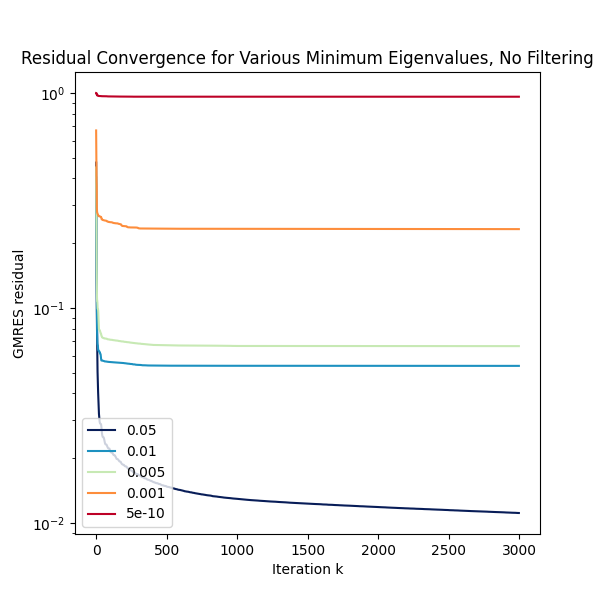

In [201]:
plt.figure()
case_num = 0
for min_eval in minevals:
  for sigma in sigmas:
    sim_case = f'mineval_{min_eval}_n_{num_iter}_s_{sigma}'
    try:
      with open(f'{outdir}{sim_case}/results.pkl','rb') as f:
        result = pickle.load(f)
    except Exception as e:
      print(f'Error {e}, moving on')
      continue
    #for result in results:
    #  if sim_case == result['test_case']:
    try:
      plt.plot(result['metricEst']['rks'],color=interp_colors[case_num],label=f'{min_eval}')
      case_num += 3
    except Exception as e:
      keys = result['metricEst'].keys()
      print(f'Error {e} for {sim_case}, keys: {keys}')
plt.legend()
plt.yscale('log')
plt.xlabel('Iteration k')
plt.ylabel('GMRES residual')
plt.title('Residual Convergence for Various Minimum Eigenvalues, No Filtering')
#plt.ylim((10e-5,1))
plt.show()


In [251]:
#paths = [(geox, geoy, geoz)]
paths = [orig_geos[0]]
outdir = outdirs[0]
run_case = cases[0]
alpha = alphas[0]
sim_paths = []
labels = ["Original Geodesic"]
colors = [eul_colors[0]]
case_num = 0
for min_eval in minevals:
  for sigma in sigmas:
    sim_case = f'mineval_{min_eval}_n_{num_iter}_s_{sigma}'
    try:
      with open(f'{outdir}{sim_case}/results.pkl','rb') as f:
        result = pickle.load(f)
    except Exception as e:
      print(f'Error {e}, moving on')
      continue
    for path_res in result["paths"]:
      try:
        paths.append((path_res['shooting']['x'][:-1],path_res['shooting']['y'][:-1],path_res['shooting']['z'][:-1]))
        labels.append(f'{run_case}_{sim_case}')
        colors.append(interp_colors[case_num])
        case_num += 3
      except Exception as e:
        keys = result['metricEst'].keys()
        print(f'Error {e} for {sim_case}, keys: {keys}')



#paths.append((eulx, euly, eulz)) 
paths.append(orig_eulers[0])
labels.append("Euler")
colors.append(eul_colors[1])
vwr = view_3d_paths(alpha,
                    paths=paths, labels=labels, colors=colors)

vwr

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [252]:
#paths = [(geox, geoy, geoz)]
paths = [orig_geos[1]]
outdir = outdirs[1]
run_case = cases[1]
alpha = alphas[1]
sim_paths = []
labels = ["Original Geodesic"]
colors = [eul_colors[0]]
case_num = 0
for min_eval in minevals:
  for sigma in sigmas:
    sim_case = f'mineval_{min_eval}_n_{num_iter}_s_{sigma}'
    try:
      with open(f'{outdir}{sim_case}/results.pkl','rb') as f:
        result = pickle.load(f)
    except Exception as e:
      print(f'Error {e}, moving on')
      continue
    for path_res in result["paths"]:
      try:
        paths.append((path_res['shooting']['x'][:-1],path_res['shooting']['y'][:-1],path_res['shooting']['z'][:-1]))
        labels.append(f'{run_case}_{sim_case}')
        colors.append(interp_colors[case_num])
        case_num += 3
      except Exception as e:
        keys = result['metricEst'].keys()
        print(f'Error {e} for {sim_case}, keys: {keys}')



#paths.append((eulx, euly, eulz)) 
paths.append(orig_eulers[0])
labels.append("Euler")
colors.append(eul_colors[1])
vwr = view_3d_paths(alpha,
                    paths=paths, labels=labels, colors=colors)

vwr

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [253]:
#paths = [(geox, geoy, geoz)]
paths = [orig_geos[2]]
outdir = outdirs[2]
run_case = cases[2]
alpha = alphas[2]
sim_paths = []
labels = ["Original Geodesic"]
colors = [eul_colors[0]]
case_num = 0
for min_eval in minevals:
  for sigma in sigmas:
    sim_case = f'mineval_{min_eval}_n_{num_iter}_s_{sigma}'
    try:
      with open(f'{outdir}{sim_case}/results.pkl','rb') as f:
        result = pickle.load(f)
    except Exception as e:
      print(f'Error {e}, moving on')
      continue
    for path_res in result["paths"]:
      try:
        paths.append((path_res['shooting']['x'][:-1],path_res['shooting']['y'][:-1],path_res['shooting']['z'][:-1]))
        labels.append(f'{run_case}_{sim_case}')
        colors.append(interp_colors[case_num])
        case_num += 3
      except Exception as e:
        keys = result['metricEst'].keys()
        print(f'Error {e} for {sim_case}, keys: {keys}')



#paths.append((eulx, euly, eulz)) 
paths.append(orig_eulers[0])
labels.append("Euler")
colors.append(eul_colors[1])
vwr = view_3d_paths(alpha,
                    paths=paths, labels=labels, colors=colors)

vwr

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

# Compare Effect of minevals at 3000 Iterations With Filtering

In [245]:
num_iter = 3000
#minevals = [0.05, 0.01, 0.005, 0.001, 5e-10]
#num_iter = 450
#minevals = [0.01, 0.005]
#sigmas = [None, 1.5]
#num_iter = 50
minevals = [0.005]
sigmas = [1.5]

<IPython.core.display.Javascript object>


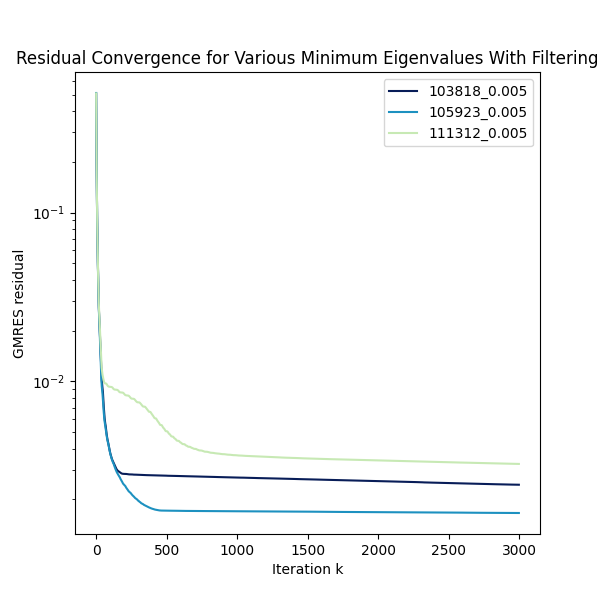

In [246]:
plt.figure()
case_num = 0
for run_case, outdir in zip(cases,outdirs):
  for min_eval in minevals:
    for sigma in sigmas:
      sim_case = f'mineval_{min_eval}_n_{num_iter}_s_{sigma}'
      try:
        with open(f'{outdir}{sim_case}/results.pkl','rb') as f:
          result = pickle.load(f)
      except Exception as e:
        print(f'Error {e}, moving on')
        continue
      try:
        plt.plot(result['metricEst']['rks'],color=interp_colors[case_num],label=f'{run_case}_{min_eval}')
        case_num += 3
      except Exception as e:
        keys = result['metricEst'].keys()
        print(f'Error {e} for {sim_case}, keys: {keys}')
plt.legend()
plt.yscale('log')
plt.xlabel('Iteration k')
plt.ylabel('GMRES residual')
plt.title('Residual Convergence for Various Minimum Eigenvalues With Filtering')
#plt.ylim((10e-5,1))
plt.show()

In [242]:
paths = [(geox, geoy, geoz)]
sim_paths = []
labels = ["Original Geodesic"]
colors = [eul_colors[0]]
case_num = 0
for min_eval in minevals:
  for sigma in sigmas:
    sim_case = f'mineval_{min_eval}_n_{num_iter}_s_{sigma}'
    try:
      with open(f'{outdir}{sim_case}/results.pkl','rb') as f:
        result = pickle.load(f)
    except Exception as e:
      print(f'Error {e}, moving on')
      continue
    for path_res in result["paths"]:
      try:
        paths.append((path_res['shooting']['x'][:-1],path_res['shooting']['y'][:-1],path_res['shooting']['z'][:-1]))
        labels.append(sim_case)
        colors.append(interp_colors[case_num])
        case_num += 3
      except Exception as e:
        keys = result['metricEst'].keys()
        print(f'Error {e} for {sim_case}, keys: {keys}')

paths.append((eulx, euly, eulz)) 
labels.append("Euler")
colors.append(eul_colors[1])
vwr = view_3d_paths(#alpha,
                    result["metricEst"][],
                    paths=paths, labels=labels, colors=colors)

vwr

SyntaxError: invalid syntax (<ipython-input-242-f28016b7d621>, line 29)

# Look at Stability of Geodesics Across Iterations Without Filtering

In [187]:
num_iters = [50,250,450,1000,3000]
minevals = [0.05, 0.01, 0.005, 0.001, 5e-10]
#sigmas = [None, 1.5]
#num_iter = 50
#minevals = [0.05]
sigmas = [None]

In [188]:
plt.figure()
case_num = 0
for min_eval in minevals:
  for sigma in sigmas:
    success=False
    for num_iter in num_iters[::-1]:
      if success:
        break
      sim_case = f'mineval_{min_eval}_n_{num_iter}_s_{sigma}'
      try:
        with open(f'{outdir}{sim_case}/results.pkl','rb') as f:
          result = pickle.load(f)
      except Exception as e:
        print(f'Error {e}, moving on')
        continue
      try:
        plt.plot(result['metricEst']['rks'],color=interp_colors[case_num],label=f'{min_eval}_{sigma}')
        success=True
        case_num += 3
      except Exception as e:
        keys = result['metricEst'].keys()
        print(f'Error {e} for {sim_case}, keys: {keys}')

plt.legend()
plt.yscale('log')
plt.xlabel('Iteration k')
plt.ylabel('GMRES residual')
plt.title('Residual Convergence for Various Minimum Eigenvalues, No Filtering')
#plt.ylim((10e-5,1))
plt.show()

<IPython.core.display.Javascript object>

In [189]:
paths = [(geox, geoy, geoz)]
sim_paths = []
labels = ["Original Geodesic"]
colors = [eul_colors[0]]
case_num = 0
for min_eval in minevals:
  case_num = 0 # Want to use same colors to represent iteration number
  for num_iter in num_iters:
    for sigma in sigmas:
      sim_case = f'mineval_{min_eval}_n_{num_iter}_s_{sigma}'
      try:
        with open(f'{outdir}{sim_case}/results.pkl','rb') as f:
          result = pickle.load(f)
      except Exception as e:
        print(f'Error {e}, moving on')
        continue
      for path_res in result["paths"]:
        try:
          paths.append((path_res['shooting']['x'][:-1],path_res['shooting']['y'][:-1],path_res['shooting']['z'][:-1]))
          labels.append(sim_case)
          colors.append(interp_colors[case_num])
          case_num += 3
          if case_num >= len(interp_colors):
            case_num = 0
        except Exception as e:
          keys = result['metricEst'].keys()
          print(f'Error {e} for {sim_case}, keys: {keys}')



paths.append((eulx, euly, eulz)) 
labels.append("Euler")
colors.append(eul_colors[1])
vwr = view_3d_paths(alpha,
                    paths=paths, labels=labels, colors=colors)

vwr

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

# Look at Stability of Geodesics Across Iterations With Filtering

In [206]:
num_iters = [50,250,450,1000,3000]
minevals = [0.05, 0.01, 0.005, 0.001, 5e-10]
#sigmas = [None, 1.5]
#num_iter = 50
#minevals = [0.05]
sigmas = [1.5]

In [207]:
paths = [(geox, geoy, geoz)]
sim_paths = []
labels = ["Original Geodesic"]
colors = [eul_colors[0]]
case_num = 0
for min_eval in minevals:
  case_num = 0 # Want to use same colors to represent iteration number
  for num_iter in num_iters:
    for sigma in sigmas:
      sim_case = f'mineval_{min_eval}_n_{num_iter}_s_{sigma}'
      try:
        with open(f'{outdir}{sim_case}/results.pkl','rb') as f:
          result = pickle.load(f)
      except Exception as e:
        print(f'Error {e}, moving on')
        continue
      for path_res in result["paths"]:
        try:
          paths.append((path_res['shooting']['x'][:-1],path_res['shooting']['y'][:-1],path_res['shooting']['z'][:-1]))
          labels.append(sim_case)
          colors.append(interp_colors[case_num])
          case_num += 3
          if case_num >= len(interp_colors):
            case_num = 0
        except Exception as e:
          keys = result['metricEst'].keys()
          print(f'Error {e} for {sim_case}, keys: {keys}')
          print(result['metricEst']['status'])



paths.append((eulx, euly, eulz)) 
labels.append("Euler")
colors.append(eul_colors[1])
vwr = view_3d_paths(alpha,
                    paths=paths, labels=labels, colors=colors)

vwr

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

# Compare Effects of Filtering

In [192]:
num_iter = 450
minevals = [0.05, 0.01, 0.005, 0.001, 5e-10]
#sigmas = [None, 1.5]
#num_iter = 50
#minevals = [0.05]
sigmas = [None,1.5]

In [193]:
plt.figure()
case_num = 0
for min_eval in minevals:
  for sigma in sigmas:
    sim_case = f'mineval_{min_eval}_n_{num_iter}_s_{sigma}'
    try:
      with open(f'{outdir}{sim_case}/results.pkl','rb') as f:
        result = pickle.load(f)
    except Exception as e:
      print(f'Error {e}, moving on')
      continue
    #for result in results:
    #  if sim_case == result['test_case']:
    try:
      plt.plot(result['metricEst']['rks'],color=interp_colors[case_num],label=f'{min_eval}_{sigma}')
      case_num += 2
    except Exception as e:
      keys = result['metricEst'].keys()
      print(f'Error {e} for {sim_case}, keys: {keys}')
plt.legend()
plt.yscale('log')
plt.xlabel('Iteration k')
plt.ylabel('GMRES residual')
plt.title('Residual Convergence With and Without Filtering')
#plt.ylim((10e-5,1))
plt.show()

<IPython.core.display.Javascript object>

Error list index out of range for mineval_0.001_n_450_s_1.5, keys: dict_keys(['config', 'alpha', 'time', 'out_tens', 'out_mask', 'rks', 'status'])
Error list index out of range for mineval_5e-10_n_450_s_None, keys: dict_keys(['config', 'alpha', 'time', 'out_tens', 'out_mask', 'rks', 'status'])
Error list index out of range for mineval_5e-10_n_450_s_1.5, keys: dict_keys(['config', 'alpha', 'time', 'out_tens', 'out_mask', 'rks', 'status'])


In [ ]:
paths = [(geox, geoy, geoz)]
sim_paths = []
labels = ["Original Geodesic"]
colors = [eul_colors[0]]
case_num = 0
for min_eval in minevals:
  for sigma in sigmas:
    sim_case = f'mineval_{min_eval}_n_{num_iter}_s_{sigma}'
    try:
      with open(f'{outdir}{sim_case}/results.pkl','rb') as f:
        result = pickle.load(f)
    except Exception as e:
      print(f'Error {e}, moving on')
      continue
    for path_res in result["paths"]:
      try:
        paths.append((path_res['shooting']['x'][:-1],path_res['shooting']['y'][:-1],path_res['shooting']['z'][:-1]))
        labels.append(sim_case)
        colors.append(interp_colors[case_num])
        case_num += 2
      except Exception as e:
        keys = result['metricEst'].keys()
        print(f'Error {e} for {sim_case}, keys: {keys}')



paths.append((eulx, euly, eulz)) 
labels.append("Euler")
colors.append(eul_colors[1])
vwr = view_3d_paths(t1_flip[:,:,:],
                    paths=paths, labels=labels, colors=colors)

#vwr.image=t1_sitk[:,::-1,:]
vwr

Error list index out of range for mineval_0.001_n_450_s_1.5, keys: dict_keys(['config', 'alpha', 'time', 'out_tens', 'out_mask', 'rks', 'status'])
Error list index out of range for mineval_5e-10_n_450_s_None, keys: dict_keys(['config', 'alpha', 'time', 'out_tens', 'out_mask', 'rks', 'status'])
Error list index out of range for mineval_5e-10_n_450_s_1.5, keys: dict_keys(['config', 'alpha', 'time', 'out_tens', 'out_mask', 'rks', 'status'])


In [ ]:
sim_case = f'mineval_0.01_n_1000_s_None'
with open(f'{outdir}{sim_case}/results.pkl','rb') as f:
  result = pickle.load(f)

itkview(image=result['metricEst']['alpha'])

In [ ]:
sim_case = f'mineval_0.01_n_1000_s_1.5'
with open(f'{outdir}{sim_case}/results.pkl','rb') as f:
  result = pickle.load(f)

itkview(image=result['metricEst']['alpha'])

In [236]:
out_tens = result["metricEst"]["out_tens"]
print(np.min(out_tens),np.max(out_tens))

-457.81173354365484 10543.493253393948


In [237]:
print(np.min(in_tens),np.max(in_tens))

-0.0044278502 0.004516473
